In [1]:
# All Imports

import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob
from skimage import filters
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import glob


import numba
from numba import njit, prange

from keras import backend as K
from keras.layers import Layer

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback, TensorBoard
from keras import backend as keras

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

#import pylidc as pl
#from keras.backend.tensorflow_backend import set_session
import tensorflow as tf


from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')

#import pymrt as mrt
#import pymrt.geometry
import ipyvolume as ipv
import copy


import os
import glob
import uuid
import numpy as np
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from ipdb import set_trace as bp



#from image_gen import ImageDataGenerator
#from load_data import loadDataMontgomery, loadDataJSRT
#from build_model import build_UNet2D_4L

import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint



import numpy
import warnings
from keras.layers import Convolution3D, Input, merge, RepeatVector, Activation
from keras.models import Model
from keras.layers.advanced_activations import PReLU
from keras import activations, initializers, regularizers
from keras.engine import Layer, InputSpec
from keras.utils.conv_utils import conv_output_length
#from keras.utils.np_utils import conv_output_length
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.engine.topology import Layer
import functools
import tensorflow as tf
import pickle
import time



Using TensorFlow backend.


In [2]:
# Ray Tracing Code


@njit(parallel=True)
def x_y_flip(host_prjbuf_temp):
    host_prjbuf_temp_gpu  = np.copy(host_prjbuf_temp)
    host_prjbuf_1view_gpu = np.copy(host_prjbuf_temp)
    
    for i in prange(BINSx):
        for j in prange(BINSy):
            bin_ind_temp = j*BINSx+i
            bin_ind      = i*BINSy+j
            host_prjbuf_1view_gpu[bin_ind] = host_prjbuf_temp_gpu[bin_ind_temp]
    
    return host_prjbuf_1view_gpu

@njit(parallel=True)
def compute_yry(host_prj_allangle, host_scat_allangle):
    all_b_size        =  ANGLES*BINSx*BINSy
    host_yry_allangle =  np.zeros(BINSx*BINSy*ANGLES)
    
    for i in prange(all_b_size):
        if (host_prj_allangle[i] == 0):
            host_yry_allangle[i] = 0
        else:
            dif = host_prj_allangle[i] - host_scat_allangle[i]
            if (dif <= 0):
                dif = host_prj_allangle[i]
            host_yry_allangle[i] = (dif*dif)/host_prj_allangle[i]
    
    return host_yry_allangle

@njit(parallel=True)
def compute_gamma_yry(host_yry_allangle, host_gamma_allangle):
    all_b_size              = ANGLES*BINSx*BINSy
    host_gamma_yry_allangle = np.zeros(all_b_size)
    
    for i in prange(all_b_size):
        host_gamma_yry_allangle[i] = host_yry_allangle[i]*host_gamma_allangle[i]
    
    return host_gamma_yry_allangle

@njit(parallel=True)
def compute_h(host_prj_sub, host_blank_sub, host_line_sub, host_scat_sub):
    ANGLES_per_sub  = int(ANGLES/subset_num)
    sub_b_size      = int(ANGLES_per_sub*BINSx*BINSy)
    
    host_sub = np.zeros(sub_b_size)
    
    for i in prange(sub_b_size):
        y_tmp       = host_blank_sub[i]*np.exp(-host_line_sub[i])
        host_sub[i] = (host_prj_sub[i]/(y_tmp+host_scat_sub[i])-1)*y_tmp
    
    return host_sub

@njit(parallel=True)
def update_est(host_est, host_capL, host_RD, host_d, host_RDD):
    f_size    = IMGSIZx*IMGSIZy*IMGSIZz
    host_est1 = np.zeros(f_size)
    
    for i in prange(f_size):
        host_est1[i] = host_est[i]-(host_capL[i]+beta*host_RD[i])/(host_d[i]+2*beta*host_RDD[i])
        if (host_est1[i] < 0):
            host_est1[i] = 0
    
    return host_est1

@njit(parallel=True)
def regroup_prj(host_uponregroup_allangle):
    all_b_size     = int(ANGLES*BINSx*BINSy)
    ANGLES_per_sub = int(ANGLES/subset_num)
    b_size         = int(BINSx*BINSy)
    
    host_allangle_tmp = np.zeros(host_uponregroup_allangle.shape)
    flag              = 0
    
    for i in range(subset_num):
        for j in range(ANGLES_per_sub):
            for k in range(b_size):
                host_allangle_tmp[flag] = host_uponregroup_allangle[int((j*subset_num+i)*b_size+k)]
                flag = flag +1
    
    return host_allangle_tmp

import math

@cuda.jit(device=True)
def rayTrace3D_GPU_direct_notexturememory_normprj(d_normprj, x0, y0, z0, x1, y1, z1, status, sum_norm, bin_ind):
    # Perform Ray Tracing
    sum_norm = 0
    dx     = x1-x0
    dy     = y1-y0
    dz     = z1-z0
    Length = math.sqrt( dx*dx+dy*dy+dz*dz )


    if (x1 != x0):
        min_lx = (x_p0-x0)/dx
        max_lx = min_lx+IMGSIZx*Vsize_x/dx

        if (min_lx > max_lx):
            #SWAP(min_lx, max_lx);
            s_temp = min_lx
            min_lx = max_lx
            max_lx = s_temp
    else:
        # the line perpendicular to x axis
        if (x0 >= IMGSIZx*Vsize_x+x_p0 or x0<=x_p0):
            status = -1
            return
        min_lx = -1e3
        max_lx = 1e3
    
    
    if (y0 != y1):
        min_ly = (y_p0-y0)/dy
        max_ly = min_ly+IMGSIZy*Vsize_y/dy

        if (min_ly > max_ly):
            #SWAP(min_ly, max_ly);
            s_temp = min_ly
            min_ly = max_ly
            max_ly = s_temp
    else:
        # the line perpendicular to y axis
        if (y0 >= IMGSIZy*Vsize_y+y_p0 or y0 <= y_p0):
            status = -1
            return
        min_ly = -1e3
        max_ly = 1e3

    
    if (z0 != z1):
        min_lz = (z_p0-z0)/dz
        max_lz = min_lz+IMGSIZz*Vsize_z/dz
        if (min_lz > max_lz):
            #SWAP(min_lz, max_lz);
            s_temp = min_lz
            min_lz = max_lz
            max_lz = s_temp
    else:
        # the line perpendicular to z axis
        if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
            status = -1
            return
        min_lz = -1e3
        max_lz = 1e3
    
    
    max_l = max_lx
    if (max_l > max_ly):
        max_l=max_ly
    if (max_l > max_lz):
        max_l = max_lz

    min_l = min_lx
    if (min_l < min_ly):
        min_l = min_ly
    if (min_l < min_lz):
        min_l = min_lz

    if (min_l >= max_l):
        status = -1
        return
    
    if (min_lx != min_l):
        prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))

        if (x0 < x1):
            min_lx= ((prev_x+1)*Vsize_x+x_p0-x0)/ dx
        else:
            if (x0 == x1):
                min_lx = 1e3
            else:
                min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
    else:
        if (x0 < x1):
            prev_x = 0
            min_lx = ( Vsize_x+x_p0-x0 )/ dx
        else:
            prev_x = IMGSIZx-1
            min_lx = ( prev_x*Vsize_x+x_p0-x0 )/ dx
    
    if (min_ly != min_l):
        prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/Vsize_y ))
        if (y0 < y1):
            min_ly = ( (prev_y+1)*Vsize_y+y_p0-y0)/ dy
        else:
            if (y0==y1):
                min_ly = 1e3
            else:
                min_ly = (prev_y*Vsize_y+y_p0-y0)/ dy
    else:
        if (y0<y1):
            prev_y = 0
            min_ly = ( Vsize_y+y_p0-y0 )/ dy
        else:
            prev_y = IMGSIZy-1
            min_ly = ( prev_y*Vsize_y+y_p0-y0 )/ dy
    
    if (min_lz != min_l):
        prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/Vsize_z ))
        if (z0 < z1):
            min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
        else:
            if (z0 == z1):
                min_lz = 1e3
            else:
                min_lz = (prev_z*Vsize_z+z_p0-z0)/ dz
    else:
        if (z0 < z1):
            prev_z = 0
            min_lz = ( Vsize_z+z_p0-z0 )/ dz
        else:
            prev_z = (int)(IMGSIZz-1)
            min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
    
    
    min_l_new = min_lx
    if (min_l_new > min_ly):
        min_l_new = min_ly
    if (min_l_new > min_lz):
        min_l_new = min_lz
    
    incx = Vsize_x/dx
    incy = Vsize_y/dy
    incz = Vsize_z/dz

    ind = 0
    
    while ( (max_l-min_l_new)/max_l > 0.000001):
        tmp_length = (min_l_new-min_l)*Length; #<-a_ij
        if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
            sum_norm = sum_norm + 1*tmp_length
        
        ind = ind + 1
        if (min_l_new == min_lx):
            if (x0 < x1):
                prev_x = prev_x + 1
                min_lx = min_lx + incx; #Vsize_x/dx
            else:
                prev_x = prev_x - 1
                min_lx = min_lx - incx; #Vsize_x/dx;
        else:
            prev_x = prev_x


        if (min_l_new == min_ly):
            if (y0 < y1):
                prev_y = prev_y + 1
                min_ly = min_ly + incy; #Vsize_y / dy;
            else:
                prev_y = prev_y - 1
                min_ly = min_ly- incy; #Vsize_y/dy;
        else:
            prev_y = prev_y


        if (min_l_new == min_lz):
            if (z0 < z1):
                prev_z = prev_z + 1
                min_lz = min_lz + incz #Vsize_z/dz;
            else:
                prev_z = prev_z - 1
                min_lz = min_lz - incz; #Vsize_z/dz
        else:
            prev_z = prev_z

        min_l     = min_l_new
        min_l_new = min_lx

        if (min_l_new > min_ly):
            min_l_new = min_ly

        if (min_l_new>min_lz):
            min_l_new=min_lz
        
        
        tmp_length = (max_l-min_l)*Length
        if ((prev_x>=0) and (prev_x<IMGSIZx) and (prev_y>=0) and (prev_y<IMGSIZy) and (prev_z>=0) and (prev_z<IMGSIZz)):
            sum_norm = sum_norm + 1*tmp_length
        
        d_normprj[bin_ind] = sum_norm

@cuda.jit(device=True)
def rayTrace3D_GPU_direct_notexturememory(d_normprj, d_prjbuf, d_objbuf, x0, y0, z0, x1, y1, z1, status):
    ix, iy   = cuda.grid(2)
    
    status   = 0
    #sum_norm = 0
    
    for a in range(angleStart, angleEnd):
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY
        
        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        fsum_norm = 0.0
        fsum      = 0.0
        
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        
        d_normprj[bin_ind] = 0
        d_prjbuf[bin_ind]  = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz
            
            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz
            
            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    fsum_norm      = fsum_norm + 1*tmp_length
                    fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
                
                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                fsum_norm      = fsum_norm + 1*tmp_length
                fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
            status2 = 100
        
        if status2 == 100:
            d_normprj[bin_ind] = fsum_norm
            d_prjbuf[bin_ind]  = fsum
        
        cuda.syncthreads()
    
@cuda.jit
def ray_trace_gpu_manyangles_direct_notexturememory_normprj(d_normprj, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    
    status   = 0
    #sum_norm = 0
    
    for a in range(angleStart, angleEnd):
        #print(a)
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY

        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        sum_norm = 0.0
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        d_normprj[bin_ind] = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz


            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz

            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    sum_norm = sum_norm + 1*tmp_length

                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                sum_norm = sum_norm + 1*tmp_length
            status2 = 100
        if status2 == 100:
            d_normprj[bin_ind] = sum_norm
        #else:
        #    d_normprj[bin_ind] = sum_norm
#         elif status == 10:
#             d_normprj[bin_ind] = 100000
#         elif status == -1:
#             d_normprj[bin_ind] = 50000
#         else:
#             d_normprj[bin_ind] = 200000
#         d_normprj[bin_ind] = Length
        cuda.syncthreads()

@cuda.jit
def ray_trace_gpu_manyangles_direct_notexturememory_OSTR_cos(d_objbuf, d_prjbuf, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    
    status   = 0
    
    for a in range(angleStart, angleEnd):
        #print(a)
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY
        
        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        sum_norm = 0.0
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        #d_prjbuf[bin_ind] = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz


            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz

            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    sum_norm = sum_norm + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length

                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                sum_norm = sum_norm + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
            status2 = 100
        
        if status2 == 100:
            d_prjbuf[bin_ind] = sum_norm*cos_theta
        cuda.syncthreads()

@cuda.jit
def ray_trace_gpu_manyangles_direct_notexturememory_cos(d_objbuf, d_prjbuf, d_normprj, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    status   = 0
    
    for a in range(angleStart, angleEnd):
        #print(a)
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY
        
        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        fsum_norm = 0.0
        fsum      = 0.0
        
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        #d_prjbuf[bin_ind] = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz


            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz

            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    fsum_norm      = fsum_norm + 1*tmp_length
                    fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length

                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                fsum_norm      = fsum_norm + 1*tmp_length
                fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
            
            status2 = 100
        if status2 == 100:
            d_normprj[bin_ind] = fsum_norm
            d_prjbuf[bin_ind]  = fsum*cos_theta
        
        cuda.syncthreads()
    
def fprojectCB_1R_GPU_OSTR_normprj(d_normprj, d_angles, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            ray_trace_gpu_manyangles_direct_notexturememory_normprj[PRJ_GRID, PRJ_THREAD](d_normprj, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY)
            #cuda.synchronize()
    return

def fprojectCB_1R_GPU_OSTR_cos(estbuf, prj_est, d_angles, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            ray_trace_gpu_manyangles_direct_notexturememory_OSTR_cos[PRJ_GRID, PRJ_THREAD](estbuf, prj_est, d_angles, d_index, 
                                                                                           angleStart, angleEnd, nbBinsX, nbBinsY)
            cuda.synchronize()
    return

def fprojectCB_1R_GPU_SART_cos(estbuf, prj_est, d_normprj, d_angles, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            ray_trace_gpu_manyangles_direct_notexturememory_cos[PRJ_GRID, PRJ_THREAD](estbuf, prj_est, d_normprj, d_angles, 
                                                                                      d_index, angleStart, angleEnd, 
                                                                                      nbBinsX, nbBinsY)
            cuda.synchronize()
    return

@cuda.jit
def SART_prj_diff_kernel(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    
    # calculate bin index
    for a in range(angleStart, angleEnd):
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy
        
        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        if normprj[bin_ind] != 0:
            diff_line[bin_ind] = prjbuf[bin_ind]#bin_ind#(prjbuf[bin_ind] - prj_est[bin_ind])/normprj[bin_ind]
        else:
            diff_line[bin_ind] = bin_ind#1
    return

@njit(parallel=True)
def SART_prj_diff(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd):
    result_diff_line = np.zeros(prjbuf.shape)
    
    #for nbBinsX in prange(nBatchBINSx):
    #    for nbBinsY in prange(nBatchBINSy):
    for bin_ind in prange(prjbuf.shape[0]):
        if normprj[bin_ind] != 0:
            result_diff_line[bin_ind] = (prjbuf[bin_ind] - prj_est[bin_ind])/normprj[bin_ind]
        else:
            result_diff_line[bin_ind] = 0.0#prjbuf[bin_ind]#bin_ind
    
    return result_diff_line

#@njit(parallel=True)
def SART_prj_diff_old(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            SART_prj_diff_kernel[PRJ_GRID, PRJ_THREAD](diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd, nbBinsX, nbBinsY)
            cuda.synchronize()
    return
#SART_prj_diff_kernel<<<PRJ_GRID,PRJ_THREAD>>>(diff_line,prjbuf,prj_est,normprj,d_index,angleStart,angleEnd,nbBinsX,nbBinsY);
#CUT_CHECK_ERROR("Kernel execution failed");
#cudaThreadSynchronize()

#def SART_prj_diff(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd):

#@cuda.jit
def bprojectCB_4B_GPU_R_SART(d_objbuf, d_prjbuf, d_prior, d_index, 
                                   d_angles, angleStart, angleEnd, lambda_parameter, beta):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    for nbatchIDx in range(nBatchXdim):
        backprj_OSSART_gpu_manyviews_R[BACKPRJ_GRID, BACKPRJ_THREAD](d_objbuf, d_prjbuf, d_prior, d_index, 
                                                                            d_angles, angleStart, angleEnd , nbatchIDx, lambda_parameter, beta)
        cuda.synchronize()
    return

@cuda.jit
def backprj_OSSART_gpu_manyviews_R(d_objbuf, d_prjbuf, d_prior, d_index, d_angles, 
                                          angleStart, angleEnd, nbatchIDx, lambda_parameter, beta):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    tid = tx
    
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel = (ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x
    
    total_sum         = 0.0
    total_sensitivity = 0.0
    
    for a in range(angleStart, angleEnd):
        u_term    = 0.0
        
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        
        #(x0,y0,z0) - source position
        x0 = sourceR*sin_theta
        z0 = sourceR*cos_theta
        y0 = sourceY
        
        #(x1,y1,z1) - center of voxel
        x1 = (ind_x+0.5)*Vsize_x + x_p0
        y1 = (ind_y+0.5)*Vsize_y + y_p0
        z1 = (ind_z+0.5)*Vsize_z + z_p0
        
        #Check FDK paper for this weight factor. This weight can be set to 1, in a simple case
        depth_weight = (x0*x0+y0*y0+z0*z0)/((x0-x1)*(x0-x1) + (y0-y1)*(y0-y1)+(z0-z1)*(z0-z1))
        
        #Do NOT Rotate (x0,y0,z0)  -theta  around the y-axis
        y0r =y0
        x0r =x0
        z0r =z0
        
        #Do NOT Rotate (x1,y1,z1)  -theta around the y-axis
        y1r = y1
        z1r = z1
        x1r = x1
        
        if (z1r != z0r):
            t = (-detectorR - z0r) / (z1r - z0r)
            x2 = x0r + (x1r - x0r) * t
            y2 = y0r + (y1r - y0r) * t
            
            weight = 1.0
            
            # BACKPROJECTION USING INTERPOLATION
            # Calculate the continuous position (in bin_index coordinate) of the projection of voxel in the detector plane.
            imb = ((float)(x2 - x_d0)/Bsize_x)
            jmb = ((float)(y2 - y_d0)/Bsize_y)
            
            ilb = (float)(math.floor(imb))
            if (imb < (ilb+0.5)):
                ilb = ilb - 1
            
            jlb = (float)(math.floor(jmb))
            if ( jmb < (jlb+0.5)):
                jlb = jlb - 1
            
            fracI = imb - (ilb+0.5)
            fracJ = jmb - (jlb+0.5)
            
            d1 = 0
            d2 = 0
            d1_sen = 0
            d2_sen = 0
        
            # Interpolation
            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = ilb*BINSy + jlb
                d1      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d1_sen  = (1-fracI) 

            if ((ilb < BINSx-1) and (ilb >= -1) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = (ilb + 1)* BINSy+ jlb
                d1      = d1 + fracI * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d1_sen  = d1_sen + fracI 

            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy-1) and (jlb >= -1)):
                bin_ind = ilb* BINSy + jlb + 1
                d2      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d2_sen   =  1-fracI 

            if ((ilb<BINSx-1) and (ilb>=-1) and (jlb<BINSy-1) and (jlb>=-1)):
                bin_ind = (ilb + 1) * BINSy +  jlb + 1
                d2 = d2 + fracI  * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d2_sen = d2_sen + fracI
            
            u_term    = (1 - fracJ) * d1 + fracJ * d2
            u_term    = u_term*Vsize_z*depth_weight
            
            u_sensitivity = ((1-fracJ)*d1_sen+fracJ*d2_sen)
            u_sensitivity = u_sensitivity *Vsize_z*depth_weight
            
            total_sum         = total_sum + (u_term*weight)
            total_sensitivity = total_sensitivity+(u_sensitivity*weight)
    
    u_term    = 0
    beta_term = 0
    
    if(total_sensitivity != 0):
        u_term    = (total_sum/total_sensitivity)
        beta_term = (beta*d_prior[ind_voxel])/total_sensitivity
    
    d_objbuf[ind_voxel] = d_objbuf[ind_voxel]+lambda_parameter*(u_term+beta_term)
    if(d_objbuf[ind_voxel] < 0):
        d_objbuf[ind_voxel] = 0
    #if(d_objbuf[ind_voxel] > 0.1):
    #    d_objbuf[ind_voxel] = 0
    
    return

@cuda.jit
def backprj_gpu_manyviews_SBP(d_objbuf, d_prjbuf, d_index, d_angles, angleStart, angleEnd , nbatchIDx):
    # Block id in a 1D grid
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    tid = tx
    
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel = (ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x
    
    total_sum = 0.0
    
    for a in range(angleStart, angleEnd):
        u_term    = 0.0
        
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        
        #(x0,y0,z0) - source position
        x0 = sourceR*sin_theta
        z0 = sourceR*cos_theta
        y0 = sourceY
        
        #(x1,y1,z1) - center of voxel
        x1 = (ind_x+0.5)*Vsize_x + x_p0
        y1 = (ind_y+0.5)*Vsize_y + y_p0
        z1 = (ind_z+0.5)*Vsize_z + z_p0
        
        #Check FDK paper for this weight factor. This weight can be set to 1, in a simple case
        depth_weight = (x0*x0 + y0*y0 + z0*z0)/((x0-x1)*(x0-x1) + (y0-y1)*(y0-y1)+(z0-z1)*(z0-z1))
        
        y0r = y0
        x0r = x0
        z0r = z0
        
        y1r = y1
        z1r = z1
        x1r = x1
        
        if (z1r != z0r):
            t = (-detectorR - z0r) / (z1r - z0r)
            x2 = x0r + (x1r - x0r) * t
            y2 = y0r + (y1r - y0r) * t
            
            weight = 1.0
            
            # BACKPROJECTION USING INTERPOLATION
            # Calculate the continuous position (in bin_index coordinate) of the projection of voxel in the detector plane.
            imb = ((float)(x2 - x_d0)/Bsize_x)
            jmb = ((float)(y2 - y_d0)/Bsize_y)
            
            ilb = (float)(math.floor(imb))
            if (imb < (ilb+0.5)):
                ilb = ilb - 1
            
            jlb = (float)(math.floor(jmb))
            if ( jmb < (jlb+0.5)):
                jlb = jlb - 1

            fracI = imb - (ilb+0.5)
            fracJ = jmb - (jlb+0.5)
            
            d1 = 0
            d2 = 0
            
            # Interpolation
            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = ilb*BINSy + jlb
                d1      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            if ((ilb < BINSx-1) and (ilb >= -1) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = (ilb + 1)* BINSy+ jlb
                d1      = d1 + fracI * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy-1) and (jlb >= -1)):
                bin_ind = ilb* BINSy + jlb + 1
                d2      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            if ((ilb<BINSx-1) and (ilb>=-1) and (jlb<BINSy-1) and (jlb>=-1)):
                bin_ind = (ilb + 1) * BINSy +  jlb + 1
                d2 = d2 + fracI  * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            u_term    = (1 - fracJ) * d1 + fracJ * d2
            u_term    = u_term*Vsize_z*depth_weight
            total_sum = total_sum + (u_term*weight)
        
    d_objbuf[ind_voxel] = d_objbuf[ind_voxel]+total_sum        
    return


def bprojectCB_GPU_SBP(d_objbuf, d_prjbuf, d_index, d_angles, angleStart, angleEnd):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    for nbatchIDx in range(nBatchXdim):
        backprj_gpu_manyviews_SBP[BACKPRJ_GRID, BACKPRJ_THREAD](d_objbuf, d_prjbuf, d_index, d_angles, angleStart, angleEnd , nbatchIDx)
        cuda.synchronize()
    return

@njit(parallel=True)
def temp_fun1(angleStart, b_size, sub_b_size, host_prj_allangle):
    host_prj_sub = np.zeros(sub_b_size)
    for i in prange(sub_b_size):
        host_prj_sub[i]   = host_prj_allangle[angleStart*b_size+i]
    return host_prj_sub

@njit(parallel=True)
def temp_fun2(subset_num, f_size, host_capL):
    temp = np.zeros(f_size)
    for i in prange(f_size):
        temp[i] = subset_num*host_capL[i]
    return temp

@cuda.jit
def G_Fessler_prior(RDD, RD, estbuf, delta, z_xy_ratio, nbatchIDx):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Thread index
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    cent = 1
    tid  = tx
    
    # Calculate the index of the voxel being considered
    # ind_x = nbatchIDx*((int)(IMGSIZx/h_nBatchXdim))+ tid
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel=int((ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x)  #(if prj is scanner data, need x_y_flip)
    #ind_voxel=(ind_z*IMGSIZx+ind_x)*IMGSIZy+ind_y;
    
    for ind_nr_z  in range(ind_z-1, ind_z+2):
        for ind_nr_y in range(ind_y-1, ind_y+2):
            for ind_nr_x in range(ind_x-1, ind_x+2):
                distance = math.sqrt(float((ind_nr_x-ind_x)*(ind_nr_x-ind_x)+(ind_nr_y-ind_y)*(ind_nr_y-ind_y)+(ind_nr_z-ind_z)*(ind_nr_z-ind_z)*z_xy_ratio*z_xy_ratio))
                
                if (distance == 0.0):
                    distance = 1.0
                    cent     = 0
                
                if ( ind_nr_x<0  or ind_nr_y<0 or ind_nr_z<0 or ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1) ):
                    ind_nr = int(ind_voxel)
                else:
                    ind_nr = int(ind_nr_x + ind_nr_y*IMGSIZx + ind_nr_z*IMGSIZx*IMGSIZy)
                
                diff        = estbuf[ind_voxel]-estbuf[ind_nr]
                denominator = 1.0+abs(diff/delta)
                RDD_tmp     = cent*(1.0/distance)/denominator
                
                RDD[ind_voxel] = RDD[ind_voxel] + RDD_tmp
                RD[ind_voxel]  = RD[ind_voxel]  + RDD_tmp*diff
                
                cent = 1 # reset cent
    return

@cuda.jit
def G_Huber_prior_sart(priorbuf, estbuf, delta, nbatchIDx):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Thread index
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    cent = 1
    tid  = tx
    
    # Calculate the index of the voxel being considered
    # ind_x = nbatchIDx*((int)(IMGSIZx/h_nBatchXdim))+ tid
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel = int((ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x)  #(if prj is scanner data, need x_y_flip)
    #ind_voxel=(ind_z*IMGSIZx+ind_x)*IMGSIZy+ind_y;
    
    for ind_nr_z  in range(ind_z-1, ind_z+2):
        for ind_nr_y in range(ind_y-1, ind_y+2):
            for ind_nr_x in range(ind_x-1, ind_x+2):
                distance = math.sqrt(float((ind_nr_x-ind_x)*(ind_nr_x-ind_x)+(ind_nr_y-ind_y)*(ind_nr_y-ind_y)+(ind_nr_z-ind_z)*(ind_nr_z-ind_z)))
                
                if (distance == 0.0):
                    distance = 1.0
                
                if ( ind_nr_x<0  or ind_nr_y<0 or ind_nr_z<0 or ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1) ):
                    ind_nr = int(ind_voxel)
                else:
                    ind_nr = int(ind_nr_x + ind_nr_y*IMGSIZx + ind_nr_z*IMGSIZx*IMGSIZy)
                
                diff        = estbuf[ind_voxel]-estbuf[ind_nr]
                denominator = math.sqrt(1.0+(diff/delta)*(diff/delta))
                
                priorbuf[ind_voxel] = priorbuf[ind_voxel] + (1.0/distance)*diff/denominator
    return    

def prior_GPU_SART(d_prior, d_est, delta):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    if (delta == 0):
        print("delta cannot be ZERO !!")
        exit(1)
    
    for nbatchIDx in range(0, nBatchXdim):
        G_Huber_prior_sart[BACKPRJ_GRID, BACKPRJ_THREAD](d_prior, d_est, delta, nbatchIDx)
        # Check out the content of this kernel in file ConebeamCT_kernel.cu
        cuda.synchronize()
    return

def prior_GPU_OSTR(d_RDD, d_RD, d_est, delta, z_xy_ratio):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    if (delta == 0):
        print("delta cannot be ZERO !!")
        exit(1)
    
    for nbatchIDx in range(0, nBatchXdim):
        G_Fessler_prior[BACKPRJ_GRID, BACKPRJ_THREAD](d_RDD, d_RD, d_est, delta, z_xy_ratio, nbatchIDx)
        # Check out the content of this kernel in file ConebeamCT_kernel.cu
        cuda.synchronize()
    return



In [3]:
# File Reading Code

def load_prj_ima(breast_type):
    b_size = BINSx*BINSy
    flag2  = 0
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    
    print(BINSx*BINSy, ANGLES, prj_allangle.shape)
    x = []
    y = []

    proj_paths = glob.glob("/media/dril/ubuntudata/DBT_recon_data/"+projection_name+"/CE*.IMA")
    for p in proj_paths:
        if '.0000.' in p:
            continue
        
        a    = pydicom.dcmread(p)
        temp = a.pixel_array.T
        temp = np.log(10000)-np.log(temp)
        # Sharpening filter
        temp = unsharp_mask(temp, radius=3, amount=1, preserve_range=True)
        thresh_min      = threshold_minimum(temp)
        binary_adaptive = temp > thresh_min
        temp = np.multiply(temp, binary_adaptive)
            
        if breast_type == "right":
            temp = np.fliplr(temp)
            temp = temp[-BINSy:]
        else:
            temp = temp[:BINSy]
            temp = np.flipud(temp)
        
        temp = temp.flatten()
        temp = x_y_flip(temp)
        
        x.append(temp)
        y.append(float(a[0x00181530].value))
    y = np.array(y)*np.pi/180
    
    print("length x ", len(x), " ", len(y))
    y, x = zip(*sorted(zip(y, x)))
    for j in range(len(x)):
        print("Proj ", j)
        flag2 = j
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = x[j][i]
    
    return prj_allangle, y

def import_param():
    for i in range(ANGLES):
        index[i] = i
    return index

def load_prj():
    b_size = BINSx*BINSy
    flag2  = 0
    
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    scat_allangle = np.zeros(BINSx*BINSy*ANGLES)
    
    for viewangle in range(ANGLES):
        s        = viewangle + 1
        filename = basepath + filepath+str(s).zfill(4)#+'.raw'
        
        with open(filename, 'rb') as f:
            primary_plus_scatter  = np.fromfile(f, dtype=np.float32)
            host_prj_temp1        = primary_plus_scatter[:b_size]
            host_prj_temp2        = primary_plus_scatter[b_size:]
        
        host_prj_1view_temp = x_y_flip(host_prj_temp1)
        host_sct_1view_temp = x_y_flip(host_prj_temp2)
        
        print(host_prj_1view_temp.shape)
        
        # all angle together
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = host_prj_1view_temp[i]
            scat_allangle[flag2*BINSx*BINSy + i] = host_sct_1view_temp[i]
        
        flag2 = flag2+1
    return prj_allangle, scat_allangle
    
def load_prj_std(data_type):
    b_size = BINSx*BINSy
    flag2  = 0
    
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    #scat_allangle = np.zeros(BINSx*BINSy*ANGLES)
    
    for viewangle in range(ANGLES):
        s        = viewangle + 1
        
        if data_type   == 0:
            #filename = basepath + 'OSTR_prelog/'+projection_name+str(s).zfill(4)#+".raw"
            filename = basepath + 'Projections_Renamed_Seg/'+projection_name+str(s).zfill(4)#+".raw"
        elif data_type == 1:
            filename = basepath + 'OSTR_scatter/'+scatter_name+str(s).zfill(4)#+".raw"
        else:
            filename = basepath + 'OSTR_blank/'+blank_name+str(s).zfill(4)#+".raw"
        
        #print(filename)
        with open(filename, 'rb') as f:
            #data  = np.load(f)
            data  = np.fromfile(f, dtype=np.float32)
            # If doign SART
            #data  = np.log(10000) - np.log(data)
            
            #print(data.shape)
            #data  = np.reshape(data, (1400, 3584))
            #data  = data[:1400, :]
            #data  = np.flip(data, 0)
            #data  = data.flatten()
            #print(data.shape)
                #data  = np.fromfile(f, dtype=np.float32)
        #np.save(filename+'.npy', data)
        proj = x_y_flip(data)
        
        # all angle together
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = proj[i]
        
        flag2 = flag2+1
    
    return prj_allangle


In [4]:
# All settings
# CE18
# x_p0    = -116.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE05
# x_p0    = -116.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE08
# x_p0    = -116.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE11
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE24
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0


In [5]:
# Settings Part


projection_name = "CE06"#"CE26.3584x1000."#"OSTR_LE.3584x1400."
scatter_name    = "OSTR_scatter.3584x1400." 
blank_name      = "OSTR_blank.3584x1400."

IMGSIZx = 2600
IMGSIZy = 1200
IMGSIZz = 48
f_size  = IMGSIZx*IMGSIZy*IMGSIZz

BINSx   = 3584
#BINSy   = 2816
BINSy   = 1600

Vsize_x = 0.085
Vsize_y = 0.085
Vsize_z = 1

x_p0    = -126.25
y_p0    = -115.1
z_p0    = -30.0

x_d0    = -152.32
y_d0    = -137.7

Bsize_x = 0.085
Bsize_y = 0.085
b_size  = BINSx*BINSy

ANGLES  = 25
index   = []
angles  = []


detectorR = 47.0
sourceR   = 608.5
sourceY   = 0.0

# Tuning Parameters
beta  = 1000
delta = 0.03
#####################

iter_num   = 5
subset_num = 5

IO_Iter = 0
method  = 0


BACKPRJ_ThreX = 390
BACKPRJ_ThreY = 1
BACKPRJ_GridX = 1000
BACKPRJ_GridY = 48
nBatchXdim    = 8

nBatchBINSx = 1
nBatchBINSy = 1

PRJ_ThreX = 16
PRJ_ThreY = 16
PRJ_GridX = 224
PRJ_GridY = 100


f_size     = IMGSIZx*IMGSIZy*IMGSIZz
all_b_size = ANGLES*BINSx*BINSy
sub_b_size = BINSx*BINSy

In [ ]:
# Code for doing SART Recon
#h_angles
host_prj_allangle_backup, h_angles   = load_prj_ima("left")
h_angles = list(h_angles)

h_index   = np.array(list(range(0, 25)))

d_angles = cuda.to_device(h_angles)
d_index  = cuda.to_device(h_index)

angleStart = 0
angleEnd   = 25


host_prj_allangle   = copy.deepcopy(host_prj_allangle_backup) #load_prj_std(0) # Load prelog  data

host_prj_allangle   = regroup_prj(host_prj_allangle)

index_tmp = np.zeros(ANGLES)
for i in range(0, ANGLES):
    index_tmp[i] = h_index[i]

flag           = 0
ANGLES_per_sub = int(ANGLES/subset_num)
h_index        = np.zeros(ANGLES, dtype=int)

for i in range(0, subset_num):
    for j in range(0, ANGLES_per_sub):
        h_index[flag] = index_tmp[j*subset_num+i]
        flag          = flag + 1
        


sub_b_size     = ANGLES_per_sub*b_size

print('sub_b_size is ', sub_b_size)
print('delta is ',      delta)
print("Indexes are ",   h_index)

In [ ]:
# Recon Loop

delta_array      = [0.0005]#[0.0001, 0.0002, 0.0003, 0.0005, 0.0006, 0.0007, 0.001]
beta_array       = [-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0]#[-0.7, -0.5, -0.3, -0.1, 0]
lambda_parameter = 0.9

for delta in delta_array:
    for beta in beta_array:
        print("Reconstructing ", beta, delta)
        
        d_line_sub     = cuda.device_array(int(sub_b_size))
        d_normprj      = cuda.device_array(int(sub_b_size))

        d_index        = cuda.to_device(h_index)

        host_est      = np.zeros(f_size, np.float32)
        d_est         = cuda.to_device(host_est)

        host_prj_est  = np.zeros(f_size, np.float32)
        prj_est       = cuda.to_device(host_prj_est)

        host_prj_est  = np.zeros(f_size, np.float32)
        prj_est       = cuda.to_device(host_prj_est)

        d_prior       = np.zeros(f_size, np.float32)
        d_prior       = cuda.to_device(d_prior)

        d_diff_line_sub = cuda.device_array(int(sub_b_size))
        d_normprj_sub   = cuda.device_array(int(sub_b_size))
        d_prj_est_sub   = cuda.device_array(int(sub_b_size))
        #d_prj_buf_sub   = cuda.device_array(int(sub_b_size))

        for i in range(0, 5):
            #print("Iteration ", i)
            for a in range(0, 5):
                angleStart = a*ANGLES_per_sub
                angleEnd   = (a+1)*ANGLES_per_sub

                host_prj_sub  = temp_fun1(angleStart, b_size, sub_b_size, host_prj_allangle)
                d_prj_buf_sub = cuda.to_device(host_prj_sub)

                d_prior       = np.zeros(f_size, np.float32)
                d_prior       = cuda.to_device(d_prior)

                prior_GPU_SART(d_prior, d_est, delta)

                fprojectCB_1R_GPU_SART_cos(
                    d_est,
                    d_prj_est_sub,
                    d_normprj_sub,
                    d_angles,
                    d_index,
                    angleStart,
                    angleEnd)

                #d_normprj_sub
                h_diff_line_sub  = d_diff_line_sub.copy_to_host()
                h_normprj_sub    = d_normprj_sub.copy_to_host()
                h_prj_est_sub    = d_prj_est_sub.copy_to_host()

                #h_normprj_sub[h_normprj_sub  < 0.5] = 10000

                result_diff = SART_prj_diff(h_diff_line_sub,
                    host_prj_sub,
                    h_prj_est_sub,
                    h_normprj_sub,
                    h_index,
                    angleStart,
                    angleEnd)

                #result_diff[result_diff > 0.5] = 0
                #result_diff[result_diff > 100] = 0
                #result_diff = np.nan_to_num(np.divide(host_prj_sub - h_prj_est_sub, h_normprj_sub))

                d_diff_line_sub = cuda.to_device(result_diff)

                bprojectCB_4B_GPU_R_SART (d_est, d_diff_line_sub, d_prior,
                                          d_index,
                                          d_angles,
                                          angleStart,
                                          angleEnd,
                                          lambda_parameter, beta)

                d_prj_est_sub = np.zeros(d_prj_est_sub.shape)
                d_prj_est_sub = cuda.to_device(d_prj_est_sub)

                d_normprj_sub = np.zeros(d_normprj_sub.shape)
                d_normprj_sub = cuda.to_device(d_normprj_sub)

                d_prj_buf_sub = np.zeros(d_prj_buf_sub.shape)
                d_prj_buf_sub = cuda.to_device(d_prj_buf_sub)
                
        host_est = d_est.copy_to_host()
        host_est.astype('float32').tofile('/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/'+projection_name+'_'+str(IMGSIZx)+'x'+str(IMGSIZy)+'x'+str(IMGSIZz)+'.'+str(i)+'_'+str(delta)+'_'+str(beta)+'.raw')
        

In [46]:
# CNN Models

def unet_double(pretrained_weights = None, input_size = (128, 128, 5), ):
    filter1 = 64
    filter2 = 128
    filter3 = 256
    filter4 = 512
    filter5 = 1024
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    input3 = Input((1, ))
    
    hash_val1 = Dense(128, activation='relu')(input2)
    hash_val1 = Dense(1, activation='relu')(hash_val1)
    
    hash_val2 = Dense(128, activation='relu')(input3)
    hash_val2 = Dense(1, activation='relu')(hash_val2)
    
    hash_val = Multiply()([hash_val1, hash_val2])
    
    hash_val = Dense(128, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.5)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2, input3], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.1)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-5), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_lstm(pretrained_weights = None, input_size = (128, 128, 2), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    single_input = Input(input_size)
    
    input1 = Lambda(lambda x: x[:, :, :, 0])(single_input)
    input1 = Reshape([128, 128, 1])(input1)
    
    input2 = Lambda(lambda x: x[:, :, :, 1])(single_input)
    input2 = Flatten()(input2)
    input2 = Reshape([1, 128*128])(input2) 
    input2 = Lambda(lambda x: x[:, :, 0])(input2)
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dense(1, activation='relu')(hash_val)
        
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.5)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #conv10 = Subtract()([input1, conv9])
    
    model  = Model(input = single_input, output = conv9)
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def lstm_model():
    input_size = (5, 128, 128, 1)
    
    input1     = Input(input_size)
    input2     = Input((1, ))
    
    cnn_model  = unet()
    
    #time2       = TimeDistributed(cnn_model)(input1)
    
    lstm_out1   = ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
                             padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(input1)
    
    lstm_out2   = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2),
                            return_sequences=False)(lstm_out1)
    
    input_one = Lambda(lambda x: x[:, 4, :, :, :])(input1)
    input_one = Reshape([128, 128, 1])(input_one)
    
    cnn_out1   = cnn_model([lstm_out2, input2])
    
    final_out = Subtract()([input_one, cnn_out1])
    #lstm_out1   = ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
    #                         padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(lstm_out1)
    #lstm_out1   = ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
    #                         padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(lstm_out1)
    #lstm_out2   = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2),
    #                         return_sequences=False)(lstm_out1)
    
    #input_last  = Lambda(lambda x: x[:, 4, :, :, 0])(input1)
    #input_last  = Reshape([128, 128, 1])(input_last)
    
    #conv10      = Subtract()([input1, lstm_out2])
    
    time_model  = Model(input = [input1, input2], output = final_out)
    time_model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = 'mean_absolute_error', 
                  metrics = ['mse'])
    
    return time_model

def conv_lstm_model():
    seq = Sequential()
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       input_shape=(5, 128, 128, 1),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                       padding='same', return_sequences=False))
    #seq.add(BatchNormalization())

    #seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
    #               activation='sigmoid',
    #               padding='same', data_format='channels_last'))
    
    seq.compile(loss='binary_crossentropy', optimizer='adadelta')
    
    return seq

#m = unet_double()
#print(m.summary())

In [ ]:
# Reading the Training Data for Baseline U-Net Model with Multiple Volumes

train_list = ['CE18', 'CE28', 'CE25', 'CE14', 'CE24', 'CE11', 'CE05', 'CE20', 'CE12', 'CE22']
test_list = ['CE03', 'CE07' 'CE18', 'CE27', 'CE17']

x_array = []
y_array = []
z_array = []

sample_per_volume = 100

for name in train_list:
    p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/"+name+"*.4_"+str(0.0005)+"*.raw")
    p.sort()
    
    x = np.fromfile(p[-1], dtype='float32')
    x = np.reshape(x, [48, 1200, 2600])
    x = x.astype('float16')
    
    y_vol_array = []
    for t in p[:-1]:
        print(t)
        y = np.fromfile(t, dtype='float32')
        y = np.reshape(y, [48, 1200, 2600])
        y = y.astype('float16')
        y_vol_array.append(y)
    
    count = 0
    while(True):
        ix = np.random.randint(128, 1200-128)
        iy = np.random.randint(128, 1200-128)
        iz = np.random.randint(0, 48)
    
        tempx = x[iz, ix:ix+128, iy:iy+128]
        
        if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
            continue
        
        val_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
        
        for j in range(7):
            x_array.append(tempx)
            tempy = y_vol_array[j][iz, ix:ix+128, iy:iy+128]
            y_array.append(tempy)
            z_array.append(val_list[j])
        
        count = count+1
        if count == sample_per_volume:
            break

x_array = np.expand_dims(x_array, axis=-1)
y_array = np.expand_dims(y_array, axis=-1)
z_array = np.expand_dims(z_array, axis=-1)

print(x_array.shape, y_array.shape, z_array.shape)

In [20]:
np.save('/media/dril/My Passport/TRAINING-DATA/x_array.npy', x_array)
np.save('/media/dril/My Passport/TRAINING-DATA/y_array.npy', y_array)
np.save('/media/dril/My Passport/TRAINING-DATA/z_array.npy', z_array)

In [41]:
x1 = []
y1 = []
z1 = []

for i in range(7000):
    if z_array[i, 0] == 0.2 or z_array[i, 0] == 0.4 or z_array[i, 0] == 0.6:#(i+1) % 6 == 0 or i % 6 == 0:
        continue
    else:
        x1.append(x_array[i, :, :, :])
        y1.append(y_array[i, :, :, :])
        z1.append(z_array[i, :])

x1 = np.array(x1)
y1 = np.array(y1)
z1 = np.array(z1)

print(x1.shape, y1.shape, z1.shape)

(4000, 128, 128, 1) (4000, 128, 128, 1) (4000, 1)


[0.1]


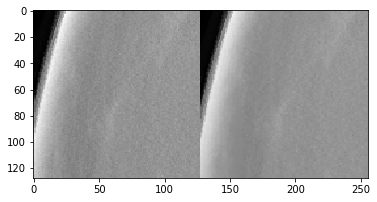

In [37]:
#print(x_array.shape, y_array.shape)
index = random.randint(0, len(x1))
print(z1[index])
plt.imshow(np.concatenate([x1[index, :, :, 0].astype('float32'), y1[index, :, :, 0].astype('float32')], axis=-1), cmap='gray')

In [47]:
# x_array = np.load('/media/dril/My Passport/TRAINING-DATA/x_array.npy')
# y_array = np.load('/media/dril/My Passport/TRAINING-DATA/y_array.npy')
# z_array = np.load('/media/dril/My Passport/TRAINING-DATA/z_array.npy')

checkpoints = ModelCheckpoint('all-data-0-to-7-0.0005-1.h5', 
                                              monitor='val_loss', verbose=0, save_best_only=True, 
                                              save_weights_only=False, mode='auto', period=1)

model = unet()
model.fit([x_array, z_array*2], y_array, 
          validation_split=0.3, 
          batch_size=8, 
          epochs=10000, callbacks=[checkpoints])

Train on 4900 samples, validate on 2100 samples
Epoch 1/10000
4900/4900 [==============================] - 28s 6ms/step - loss: 0.0023 - mean_squared_error: 2.0523e-05 - val_loss: 0.0018 - val_mean_squared_error: 6.4879e-06
Epoch 2/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 0.0017 - mean_squared_error: 4.0235e-05 - val_loss: 0.0015 - val_mean_squared_error: 5.0220e-06
Epoch 3/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 0.0015 - mean_squared_error: 2.1170e-05 - val_loss: 0.0014 - val_mean_squared_error: 4.7078e-06
Epoch 4/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 0.0015 - mean_squared_error: 1.6005e-05 - val_loss: 0.0014 - val_mean_squared_error: 4.5703e-06
Epoch 5/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 0.0014 - mean_squared_error: 1.3753e-05 - val_loss: 0.0014 - val_mean_squared_error: 4.5461e-06
Epoch 6/10000
4900/4900 [==============================] - 26s 5ms/step 

4900/4900 [==============================] - 26s 5ms/step - loss: 6.8144e-04 - mean_squared_error: 2.0084e-06 - val_loss: 6.9865e-04 - val_mean_squared_error: 2.3065e-06
Epoch 47/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 6.7615e-04 - mean_squared_error: 2.1039e-06 - val_loss: 6.9316e-04 - val_mean_squared_error: 2.2726e-06
Epoch 48/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 6.7080e-04 - mean_squared_error: 2.1686e-06 - val_loss: 6.8631e-04 - val_mean_squared_error: 2.1076e-06
Epoch 49/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 6.6251e-04 - mean_squared_error: 2.0405e-06 - val_loss: 7.0373e-04 - val_mean_squared_error: 2.2323e-06
Epoch 50/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 6.6026e-04 - mean_squared_error: 1.9009e-06 - val_loss: 6.7810e-04 - val_mean_squared_error: 2.2125e-06
Epoch 51/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 6.5518e-0

4900/4900 [==============================] - 26s 5ms/step - loss: 5.5830e-04 - mean_squared_error: 1.4431e-06 - val_loss: 5.9391e-04 - val_mean_squared_error: 1.7830e-06
Epoch 91/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 5.5505e-04 - mean_squared_error: 1.2814e-06 - val_loss: 6.1206e-04 - val_mean_squared_error: 1.7723e-06
Epoch 92/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 5.5326e-04 - mean_squared_error: 1.2540e-06 - val_loss: 5.8302e-04 - val_mean_squared_error: 1.5758e-06
Epoch 93/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 5.5068e-04 - mean_squared_error: 1.2504e-06 - val_loss: 5.8660e-04 - val_mean_squared_error: 1.7255e-06
Epoch 94/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 5.5116e-04 - mean_squared_error: 1.3078e-06 - val_loss: 5.8740e-04 - val_mean_squared_error: 1.6530e-06
Epoch 95/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 5.4891e-0

4900/4900 [==============================] - 26s 5ms/step - loss: 5.1665e-04 - mean_squared_error: 1.0320e-06 - val_loss: 5.6595e-04 - val_mean_squared_error: 1.4085e-06
Epoch 135/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 5.1525e-04 - mean_squared_error: 1.0009e-06 - val_loss: 5.5978e-04 - val_mean_squared_error: 1.4834e-06
Epoch 136/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 5.1199e-04 - mean_squared_error: 1.0097e-06 - val_loss: 5.6078e-04 - val_mean_squared_error: 1.5254e-06
Epoch 137/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 5.1484e-04 - mean_squared_error: 1.0071e-06 - val_loss: 5.6296e-04 - val_mean_squared_error: 1.5109e-06
Epoch 138/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 5.1076e-04 - mean_squared_error: 9.6174e-07 - val_loss: 5.6055e-04 - val_mean_squared_error: 1.4207e-06
Epoch 139/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 5.11

4900/4900 [==============================] - 25s 5ms/step - loss: 4.9057e-04 - mean_squared_error: 8.3478e-07 - val_loss: 5.4552e-04 - val_mean_squared_error: 1.3739e-06
Epoch 179/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.9247e-04 - mean_squared_error: 8.5131e-07 - val_loss: 5.4826e-04 - val_mean_squared_error: 1.4330e-06
Epoch 180/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.9198e-04 - mean_squared_error: 8.6955e-07 - val_loss: 5.4611e-04 - val_mean_squared_error: 1.3586e-06
Epoch 181/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 4.8978e-04 - mean_squared_error: 8.6699e-07 - val_loss: 5.5277e-04 - val_mean_squared_error: 1.3849e-06
Epoch 182/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.9081e-04 - mean_squared_error: 8.8971e-07 - val_loss: 5.5535e-04 - val_mean_squared_error: 1.3366e-06
Epoch 183/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.89

4900/4900 [==============================] - 25s 5ms/step - loss: 4.7152e-04 - mean_squared_error: 7.4326e-07 - val_loss: 5.4436e-04 - val_mean_squared_error: 1.3338e-06
Epoch 223/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 4.7085e-04 - mean_squared_error: 7.1048e-07 - val_loss: 5.3706e-04 - val_mean_squared_error: 1.3509e-06
Epoch 224/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.7111e-04 - mean_squared_error: 7.9865e-07 - val_loss: 5.3601e-04 - val_mean_squared_error: 1.3343e-06
Epoch 225/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 4.7224e-04 - mean_squared_error: 8.0372e-07 - val_loss: 5.3507e-04 - val_mean_squared_error: 1.2347e-06
Epoch 226/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 4.6823e-04 - mean_squared_error: 7.5678e-07 - val_loss: 5.3723e-04 - val_mean_squared_error: 1.3356e-06
Epoch 227/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.70

4900/4900 [==============================] - 26s 5ms/step - loss: 4.5352e-04 - mean_squared_error: 6.8260e-07 - val_loss: 5.3575e-04 - val_mean_squared_error: 1.2925e-06
Epoch 267/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.5778e-04 - mean_squared_error: 6.7443e-07 - val_loss: 5.3423e-04 - val_mean_squared_error: 1.3816e-06
Epoch 268/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.5191e-04 - mean_squared_error: 6.7175e-07 - val_loss: 5.3653e-04 - val_mean_squared_error: 1.3957e-06
Epoch 269/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.5342e-04 - mean_squared_error: 6.9956e-07 - val_loss: 5.2975e-04 - val_mean_squared_error: 1.2384e-06
Epoch 270/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.5314e-04 - mean_squared_error: 6.7152e-07 - val_loss: 5.3389e-04 - val_mean_squared_error: 1.2763e-06
Epoch 271/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.56

4900/4900 [==============================] - 25s 5ms/step - loss: 4.3911e-04 - mean_squared_error: 6.0598e-07 - val_loss: 5.2219e-04 - val_mean_squared_error: 1.2093e-06
Epoch 311/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.4135e-04 - mean_squared_error: 6.0426e-07 - val_loss: 5.2448e-04 - val_mean_squared_error: 1.1512e-06
Epoch 312/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.4099e-04 - mean_squared_error: 6.2366e-07 - val_loss: 5.2544e-04 - val_mean_squared_error: 1.2330e-06
Epoch 313/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.4270e-04 - mean_squared_error: 6.2704e-07 - val_loss: 5.3400e-04 - val_mean_squared_error: 1.3431e-06
Epoch 314/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 4.3943e-04 - mean_squared_error: 6.7640e-07 - val_loss: 5.2530e-04 - val_mean_squared_error: 1.2018e-06
Epoch 315/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.39

4900/4900 [==============================] - 26s 5ms/step - loss: 4.3336e-04 - mean_squared_error: 6.1236e-07 - val_loss: 5.2841e-04 - val_mean_squared_error: 1.2807e-06
Epoch 355/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 4.2821e-04 - mean_squared_error: 5.4571e-07 - val_loss: 5.2646e-04 - val_mean_squared_error: 1.2299e-06
Epoch 356/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.3023e-04 - mean_squared_error: 5.7936e-07 - val_loss: 5.2056e-04 - val_mean_squared_error: 1.1848e-06
Epoch 357/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.3061e-04 - mean_squared_error: 6.2940e-07 - val_loss: 5.2321e-04 - val_mean_squared_error: 1.2560e-06
Epoch 358/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.3093e-04 - mean_squared_error: 6.4954e-07 - val_loss: 5.2206e-04 - val_mean_squared_error: 1.2403e-06
Epoch 359/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 4.28

4900/4900 [==============================] - 26s 5ms/step - loss: 4.2107e-04 - mean_squared_error: 6.0980e-07 - val_loss: 5.1980e-04 - val_mean_squared_error: 1.2205e-06
Epoch 399/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.2135e-04 - mean_squared_error: 5.1117e-07 - val_loss: 5.1970e-04 - val_mean_squared_error: 1.2518e-06
Epoch 400/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.2199e-04 - mean_squared_error: 5.4175e-07 - val_loss: 5.2498e-04 - val_mean_squared_error: 1.2939e-06
Epoch 401/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.2184e-04 - mean_squared_error: 5.2003e-07 - val_loss: 5.2576e-04 - val_mean_squared_error: 1.2398e-06
Epoch 402/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.2154e-04 - mean_squared_error: 5.3375e-07 - val_loss: 5.2398e-04 - val_mean_squared_error: 1.2247e-06
Epoch 403/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 4.21

4900/4900 [==============================] - 26s 5ms/step - loss: 4.1349e-04 - mean_squared_error: 4.9590e-07 - val_loss: 5.2266e-04 - val_mean_squared_error: 1.3245e-06
Epoch 443/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.1496e-04 - mean_squared_error: 5.0946e-07 - val_loss: 5.2024e-04 - val_mean_squared_error: 1.2780e-06
Epoch 444/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 4.1403e-04 - mean_squared_error: 5.2406e-07 - val_loss: 5.2141e-04 - val_mean_squared_error: 1.2120e-06
Epoch 445/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.1359e-04 - mean_squared_error: 5.0661e-07 - val_loss: 5.2365e-04 - val_mean_squared_error: 1.1495e-06
Epoch 446/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.1304e-04 - mean_squared_error: 4.7905e-07 - val_loss: 5.1979e-04 - val_mean_squared_error: 1.2289e-06
Epoch 447/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.14

4900/4900 [==============================] - 26s 5ms/step - loss: 4.0778e-04 - mean_squared_error: 4.9093e-07 - val_loss: 5.2133e-04 - val_mean_squared_error: 1.2550e-06
Epoch 487/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.0663e-04 - mean_squared_error: 4.7389e-07 - val_loss: 5.1596e-04 - val_mean_squared_error: 1.2419e-06
Epoch 488/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.0794e-04 - mean_squared_error: 5.1775e-07 - val_loss: 5.1405e-04 - val_mean_squared_error: 1.1909e-06
Epoch 489/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.0769e-04 - mean_squared_error: 4.7903e-07 - val_loss: 5.1571e-04 - val_mean_squared_error: 1.2216e-06
Epoch 490/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 4.0703e-04 - mean_squared_error: 4.8531e-07 - val_loss: 5.1638e-04 - val_mean_squared_error: 1.1957e-06
Epoch 491/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.06

4900/4900 [==============================] - 25s 5ms/step - loss: 4.0266e-04 - mean_squared_error: 4.6898e-07 - val_loss: 5.1832e-04 - val_mean_squared_error: 1.2752e-06
Epoch 531/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.0283e-04 - mean_squared_error: 5.0262e-07 - val_loss: 5.1767e-04 - val_mean_squared_error: 1.2680e-06
Epoch 532/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.0102e-04 - mean_squared_error: 4.3443e-07 - val_loss: 5.1755e-04 - val_mean_squared_error: 1.2288e-06
Epoch 533/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.0258e-04 - mean_squared_error: 4.6290e-07 - val_loss: 5.1315e-04 - val_mean_squared_error: 1.2189e-06
Epoch 534/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 4.0117e-04 - mean_squared_error: 4.5247e-07 - val_loss: 5.1587e-04 - val_mean_squared_error: 1.1816e-06
Epoch 535/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 4.01

4900/4900 [==============================] - 26s 5ms/step - loss: 3.9593e-04 - mean_squared_error: 4.3939e-07 - val_loss: 5.1963e-04 - val_mean_squared_error: 1.1337e-06
Epoch 575/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.9698e-04 - mean_squared_error: 4.9656e-07 - val_loss: 5.1577e-04 - val_mean_squared_error: 1.2492e-06
Epoch 576/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.9536e-04 - mean_squared_error: 4.3069e-07 - val_loss: 5.1537e-04 - val_mean_squared_error: 1.2072e-06
Epoch 577/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.9436e-04 - mean_squared_error: 4.2746e-07 - val_loss: 5.2156e-04 - val_mean_squared_error: 1.3118e-06
Epoch 578/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.9544e-04 - mean_squared_error: 4.3649e-07 - val_loss: 5.1392e-04 - val_mean_squared_error: 1.1926e-06
Epoch 579/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.95

4900/4900 [==============================] - 26s 5ms/step - loss: 3.9011e-04 - mean_squared_error: 4.0193e-07 - val_loss: 5.1118e-04 - val_mean_squared_error: 1.1803e-06
Epoch 619/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.8960e-04 - mean_squared_error: 4.1931e-07 - val_loss: 5.1149e-04 - val_mean_squared_error: 1.1534e-06
Epoch 620/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.9115e-04 - mean_squared_error: 4.0791e-07 - val_loss: 5.1564e-04 - val_mean_squared_error: 1.2777e-06
Epoch 621/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.9012e-04 - mean_squared_error: 4.2262e-07 - val_loss: 5.1103e-04 - val_mean_squared_error: 1.1423e-06
Epoch 622/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.8988e-04 - mean_squared_error: 4.2054e-07 - val_loss: 5.1148e-04 - val_mean_squared_error: 1.1876e-06
Epoch 623/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.90

4900/4900 [==============================] - 26s 5ms/step - loss: 3.8593e-04 - mean_squared_error: 4.0380e-07 - val_loss: 5.1598e-04 - val_mean_squared_error: 1.1851e-06
Epoch 663/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.8627e-04 - mean_squared_error: 4.7553e-07 - val_loss: 5.1948e-04 - val_mean_squared_error: 1.2837e-06
Epoch 664/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.8573e-04 - mean_squared_error: 4.1838e-07 - val_loss: 5.1356e-04 - val_mean_squared_error: 1.2053e-06
Epoch 665/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.8583e-04 - mean_squared_error: 3.9783e-07 - val_loss: 5.1032e-04 - val_mean_squared_error: 1.1646e-06
Epoch 666/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.8551e-04 - mean_squared_error: 4.0983e-07 - val_loss: 5.1334e-04 - val_mean_squared_error: 1.2322e-06
Epoch 667/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.84

4900/4900 [==============================] - 26s 5ms/step - loss: 3.8142e-04 - mean_squared_error: 3.7191e-07 - val_loss: 5.1250e-04 - val_mean_squared_error: 1.2188e-06
Epoch 707/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.8100e-04 - mean_squared_error: 4.0356e-07 - val_loss: 5.1484e-04 - val_mean_squared_error: 1.2104e-06
Epoch 708/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.8014e-04 - mean_squared_error: 3.6521e-07 - val_loss: 5.1360e-04 - val_mean_squared_error: 1.2309e-06
Epoch 709/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.8175e-04 - mean_squared_error: 4.1634e-07 - val_loss: 5.1433e-04 - val_mean_squared_error: 1.2351e-06
Epoch 710/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.8065e-04 - mean_squared_error: 3.9373e-07 - val_loss: 5.1085e-04 - val_mean_squared_error: 1.1911e-06
Epoch 711/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.81

4900/4900 [==============================] - 25s 5ms/step - loss: 3.7664e-04 - mean_squared_error: 3.4982e-07 - val_loss: 5.0978e-04 - val_mean_squared_error: 1.1724e-06
Epoch 751/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.7665e-04 - mean_squared_error: 3.7022e-07 - val_loss: 5.0991e-04 - val_mean_squared_error: 1.1895e-06
Epoch 752/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.7809e-04 - mean_squared_error: 3.9156e-07 - val_loss: 5.1211e-04 - val_mean_squared_error: 1.2190e-06
Epoch 753/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.7682e-04 - mean_squared_error: 3.5881e-07 - val_loss: 5.0743e-04 - val_mean_squared_error: 1.1376e-06
Epoch 754/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.7661e-04 - mean_squared_error: 3.9443e-07 - val_loss: 5.1008e-04 - val_mean_squared_error: 1.1571e-06
Epoch 755/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.77

4900/4900 [==============================] - 25s 5ms/step - loss: 3.7330e-04 - mean_squared_error: 3.4261e-07 - val_loss: 5.0660e-04 - val_mean_squared_error: 1.1226e-06
Epoch 795/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.7362e-04 - mean_squared_error: 3.8796e-07 - val_loss: 5.0444e-04 - val_mean_squared_error: 1.0839e-06
Epoch 796/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.7296e-04 - mean_squared_error: 3.5135e-07 - val_loss: 5.0690e-04 - val_mean_squared_error: 1.1602e-06
Epoch 797/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.7306e-04 - mean_squared_error: 3.9770e-07 - val_loss: 5.1129e-04 - val_mean_squared_error: 1.2207e-06
Epoch 798/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.7208e-04 - mean_squared_error: 3.8558e-07 - val_loss: 5.1462e-04 - val_mean_squared_error: 1.2749e-06
Epoch 799/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.73

4900/4900 [==============================] - 25s 5ms/step - loss: 3.6883e-04 - mean_squared_error: 3.3404e-07 - val_loss: 5.0936e-04 - val_mean_squared_error: 1.1845e-06
Epoch 839/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.6969e-04 - mean_squared_error: 4.2927e-07 - val_loss: 5.0722e-04 - val_mean_squared_error: 1.1387e-06
Epoch 840/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.6837e-04 - mean_squared_error: 3.4549e-07 - val_loss: 5.1127e-04 - val_mean_squared_error: 1.2763e-06
Epoch 841/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.6930e-04 - mean_squared_error: 3.5819e-07 - val_loss: 5.1257e-04 - val_mean_squared_error: 1.2122e-06
Epoch 842/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.7005e-04 - mean_squared_error: 3.8329e-07 - val_loss: 5.0412e-04 - val_mean_squared_error: 1.0914e-06
Epoch 843/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.68

4900/4900 [==============================] - 25s 5ms/step - loss: 3.6572e-04 - mean_squared_error: 3.3752e-07 - val_loss: 5.0837e-04 - val_mean_squared_error: 1.1270e-06
Epoch 883/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.6544e-04 - mean_squared_error: 3.4769e-07 - val_loss: 5.0969e-04 - val_mean_squared_error: 1.2324e-06
Epoch 884/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.6520e-04 - mean_squared_error: 3.3735e-07 - val_loss: 5.0827e-04 - val_mean_squared_error: 1.1504e-06
Epoch 885/10000
4900/4900 [==============================] - 24s 5ms/step - loss: 3.6501e-04 - mean_squared_error: 3.3511e-07 - val_loss: 5.0498e-04 - val_mean_squared_error: 1.1326e-06
Epoch 886/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.6603e-04 - mean_squared_error: 3.5616e-07 - val_loss: 5.1325e-04 - val_mean_squared_error: 1.1408e-06
Epoch 887/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.66

4900/4900 [==============================] - 25s 5ms/step - loss: 3.6322e-04 - mean_squared_error: 3.9654e-07 - val_loss: 5.0763e-04 - val_mean_squared_error: 1.1835e-06
Epoch 927/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.6259e-04 - mean_squared_error: 3.4948e-07 - val_loss: 5.0407e-04 - val_mean_squared_error: 1.1281e-06
Epoch 928/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.6132e-04 - mean_squared_error: 3.3529e-07 - val_loss: 5.0706e-04 - val_mean_squared_error: 1.1652e-06
Epoch 929/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.6372e-04 - mean_squared_error: 3.4539e-07 - val_loss: 5.0690e-04 - val_mean_squared_error: 1.1739e-06
Epoch 930/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.6116e-04 - mean_squared_error: 3.2192e-07 - val_loss: 5.0218e-04 - val_mean_squared_error: 1.0692e-06
Epoch 931/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.62

4900/4900 [==============================] - 25s 5ms/step - loss: 3.5990e-04 - mean_squared_error: 3.5091e-07 - val_loss: 5.0546e-04 - val_mean_squared_error: 1.1478e-06
Epoch 971/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5959e-04 - mean_squared_error: 3.1545e-07 - val_loss: 5.0441e-04 - val_mean_squared_error: 1.1754e-06
Epoch 972/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5850e-04 - mean_squared_error: 3.2982e-07 - val_loss: 5.0357e-04 - val_mean_squared_error: 1.1411e-06
Epoch 973/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.6020e-04 - mean_squared_error: 3.7341e-07 - val_loss: 5.0621e-04 - val_mean_squared_error: 1.1942e-06
Epoch 974/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5950e-04 - mean_squared_error: 3.5290e-07 - val_loss: 5.0596e-04 - val_mean_squared_error: 1.1288e-06
Epoch 975/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.59

4900/4900 [==============================] - 25s 5ms/step - loss: 3.5637e-04 - mean_squared_error: 3.3329e-07 - val_loss: 5.0334e-04 - val_mean_squared_error: 1.1197e-06
Epoch 1015/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5670e-04 - mean_squared_error: 3.3379e-07 - val_loss: 5.0457e-04 - val_mean_squared_error: 1.1655e-06
Epoch 1016/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5631e-04 - mean_squared_error: 3.2163e-07 - val_loss: 5.0488e-04 - val_mean_squared_error: 1.1879e-06
Epoch 1017/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5699e-04 - mean_squared_error: 3.2405e-07 - val_loss: 5.0515e-04 - val_mean_squared_error: 1.1397e-06
Epoch 1018/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5585e-04 - mean_squared_error: 3.2121e-07 - val_loss: 5.0827e-04 - val_mean_squared_error: 1.1950e-06
Epoch 1019/10000
4900/4900 [==============================] - 25s 5ms/step - loss:

Epoch 1058/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5335e-04 - mean_squared_error: 3.2729e-07 - val_loss: 5.0516e-04 - val_mean_squared_error: 1.1730e-06
Epoch 1059/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5504e-04 - mean_squared_error: 3.4049e-07 - val_loss: 5.0745e-04 - val_mean_squared_error: 1.2316e-06
Epoch 1060/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5327e-04 - mean_squared_error: 3.0690e-07 - val_loss: 5.0558e-04 - val_mean_squared_error: 1.1690e-06
Epoch 1061/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5445e-04 - mean_squared_error: 3.1570e-07 - val_loss: 5.0124e-04 - val_mean_squared_error: 1.1271e-06
Epoch 1062/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5333e-04 - mean_squared_error: 3.0345e-07 - val_loss: 5.0295e-04 - val_mean_squared_error: 1.1481e-06
Epoch 1063/10000
4900/4900 [==============================] - 25s

Epoch 1102/10000
4900/4900 [==============================] - 24s 5ms/step - loss: 3.5074e-04 - mean_squared_error: 3.0626e-07 - val_loss: 5.0278e-04 - val_mean_squared_error: 1.1165e-06
Epoch 1103/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5177e-04 - mean_squared_error: 3.2587e-07 - val_loss: 5.0510e-04 - val_mean_squared_error: 1.1585e-06
Epoch 1104/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5098e-04 - mean_squared_error: 3.0678e-07 - val_loss: 5.0169e-04 - val_mean_squared_error: 1.1559e-06
Epoch 1105/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5056e-04 - mean_squared_error: 2.9915e-07 - val_loss: 5.0110e-04 - val_mean_squared_error: 1.1235e-06
Epoch 1106/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.5113e-04 - mean_squared_error: 3.0287e-07 - val_loss: 5.0267e-04 - val_mean_squared_error: 1.1226e-06
Epoch 1107/10000
4900/4900 [==============================] - 25s

Epoch 1146/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4907e-04 - mean_squared_error: 2.8499e-07 - val_loss: 5.0073e-04 - val_mean_squared_error: 1.0846e-06
Epoch 1147/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4805e-04 - mean_squared_error: 3.0236e-07 - val_loss: 5.0429e-04 - val_mean_squared_error: 1.1771e-06
Epoch 1148/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4831e-04 - mean_squared_error: 3.1827e-07 - val_loss: 5.0331e-04 - val_mean_squared_error: 1.1594e-06
Epoch 1149/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4783e-04 - mean_squared_error: 2.8094e-07 - val_loss: 5.0319e-04 - val_mean_squared_error: 1.1301e-06
Epoch 1150/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4840e-04 - mean_squared_error: 3.0329e-07 - val_loss: 5.0027e-04 - val_mean_squared_error: 1.0992e-06
Epoch 1151/10000
4900/4900 [==============================] - 25s

Epoch 1190/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4687e-04 - mean_squared_error: 2.8596e-07 - val_loss: 5.0928e-04 - val_mean_squared_error: 1.1637e-06
Epoch 1191/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4679e-04 - mean_squared_error: 2.9912e-07 - val_loss: 5.0126e-04 - val_mean_squared_error: 1.1199e-06
Epoch 1192/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4675e-04 - mean_squared_error: 3.0360e-07 - val_loss: 5.0137e-04 - val_mean_squared_error: 1.1393e-06
Epoch 1193/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4568e-04 - mean_squared_error: 2.7702e-07 - val_loss: 5.0328e-04 - val_mean_squared_error: 1.1003e-06
Epoch 1194/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4592e-04 - mean_squared_error: 2.8699e-07 - val_loss: 5.0245e-04 - val_mean_squared_error: 1.1454e-06
Epoch 1195/10000
4900/4900 [==============================] - 25s

4900/4900 [==============================] - 25s 5ms/step - loss: 3.4460e-04 - mean_squared_error: 3.1625e-07 - val_loss: 4.9999e-04 - val_mean_squared_error: 1.0987e-06
Epoch 1234/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4367e-04 - mean_squared_error: 2.9062e-07 - val_loss: 5.0463e-04 - val_mean_squared_error: 1.1576e-06
Epoch 1235/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4385e-04 - mean_squared_error: 2.8597e-07 - val_loss: 5.0131e-04 - val_mean_squared_error: 1.1356e-06
Epoch 1236/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4388e-04 - mean_squared_error: 2.7697e-07 - val_loss: 4.9932e-04 - val_mean_squared_error: 1.0845e-06
Epoch 1237/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4378e-04 - mean_squared_error: 3.1044e-07 - val_loss: 5.0709e-04 - val_mean_squared_error: 1.1291e-06
Epoch 1238/10000
4900/4900 [==============================] - 25s 5ms/step - loss:

Epoch 1277/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4127e-04 - mean_squared_error: 2.6948e-07 - val_loss: 4.9902e-04 - val_mean_squared_error: 1.0905e-06
Epoch 1278/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4142e-04 - mean_squared_error: 2.7153e-07 - val_loss: 5.0437e-04 - val_mean_squared_error: 1.1231e-06
Epoch 1279/10000
4900/4900 [==============================] - 24s 5ms/step - loss: 3.4226e-04 - mean_squared_error: 2.8613e-07 - val_loss: 5.0254e-04 - val_mean_squared_error: 1.1901e-06
Epoch 1280/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4217e-04 - mean_squared_error: 3.1427e-07 - val_loss: 5.0403e-04 - val_mean_squared_error: 1.1626e-06
Epoch 1281/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4212e-04 - mean_squared_error: 2.8718e-07 - val_loss: 5.0021e-04 - val_mean_squared_error: 1.1104e-06
Epoch 1282/10000
4900/4900 [==============================] - 25s

Epoch 1321/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3958e-04 - mean_squared_error: 3.0076e-07 - val_loss: 5.0044e-04 - val_mean_squared_error: 1.1322e-06
Epoch 1322/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3940e-04 - mean_squared_error: 2.7509e-07 - val_loss: 4.9898e-04 - val_mean_squared_error: 1.0948e-06
Epoch 1323/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3887e-04 - mean_squared_error: 2.7136e-07 - val_loss: 5.0250e-04 - val_mean_squared_error: 1.1284e-06
Epoch 1324/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3915e-04 - mean_squared_error: 2.7819e-07 - val_loss: 5.0142e-04 - val_mean_squared_error: 1.1216e-06
Epoch 1325/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.4116e-04 - mean_squared_error: 3.0282e-07 - val_loss: 4.9905e-04 - val_mean_squared_error: 1.1136e-06
Epoch 1326/10000
4900/4900 [==============================] - 25s

Epoch 1365/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3830e-04 - mean_squared_error: 2.8074e-07 - val_loss: 4.9914e-04 - val_mean_squared_error: 1.1073e-06
Epoch 1366/10000
4900/4900 [==============================] - 24s 5ms/step - loss: 3.3742e-04 - mean_squared_error: 2.9486e-07 - val_loss: 5.0271e-04 - val_mean_squared_error: 1.0905e-06
Epoch 1367/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3720e-04 - mean_squared_error: 3.0690e-07 - val_loss: 5.0114e-04 - val_mean_squared_error: 1.1153e-06
Epoch 1368/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3828e-04 - mean_squared_error: 3.0661e-07 - val_loss: 5.0107e-04 - val_mean_squared_error: 1.0940e-06
Epoch 1369/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3777e-04 - mean_squared_error: 2.7474e-07 - val_loss: 4.9864e-04 - val_mean_squared_error: 1.0854e-06
Epoch 1370/10000
4900/4900 [==============================] - 25s

Epoch 1409/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3534e-04 - mean_squared_error: 2.7979e-07 - val_loss: 5.0266e-04 - val_mean_squared_error: 1.1824e-06
Epoch 1410/10000
4900/4900 [==============================] - 24s 5ms/step - loss: 3.3560e-04 - mean_squared_error: 2.8109e-07 - val_loss: 5.0017e-04 - val_mean_squared_error: 1.1459e-06
Epoch 1411/10000
4900/4900 [==============================] - 24s 5ms/step - loss: 3.3562e-04 - mean_squared_error: 2.7516e-07 - val_loss: 5.0069e-04 - val_mean_squared_error: 1.0876e-06
Epoch 1412/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3515e-04 - mean_squared_error: 2.6283e-07 - val_loss: 4.9721e-04 - val_mean_squared_error: 1.0800e-06
Epoch 1413/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3495e-04 - mean_squared_error: 2.7180e-07 - val_loss: 4.9973e-04 - val_mean_squared_error: 1.1173e-06
Epoch 1414/10000
4900/4900 [==============================] - 25s

Epoch 1453/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3382e-04 - mean_squared_error: 2.6775e-07 - val_loss: 4.9718e-04 - val_mean_squared_error: 1.0709e-06
Epoch 1454/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3411e-04 - mean_squared_error: 2.8597e-07 - val_loss: 5.0315e-04 - val_mean_squared_error: 1.1594e-06
Epoch 1455/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3404e-04 - mean_squared_error: 2.8649e-07 - val_loss: 4.9629e-04 - val_mean_squared_error: 1.0541e-06
Epoch 1456/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3326e-04 - mean_squared_error: 2.5113e-07 - val_loss: 4.9762e-04 - val_mean_squared_error: 1.0990e-06
Epoch 1457/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3486e-04 - mean_squared_error: 2.9865e-07 - val_loss: 4.9837e-04 - val_mean_squared_error: 1.0873e-06
Epoch 1458/10000
4900/4900 [==============================] - 25s

Epoch 1497/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3295e-04 - mean_squared_error: 2.9981e-07 - val_loss: 4.9879e-04 - val_mean_squared_error: 1.1193e-06
Epoch 1498/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3103e-04 - mean_squared_error: 2.5558e-07 - val_loss: 5.0060e-04 - val_mean_squared_error: 1.1135e-06
Epoch 1499/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3244e-04 - mean_squared_error: 2.9892e-07 - val_loss: 5.0075e-04 - val_mean_squared_error: 1.1211e-06
Epoch 1500/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3130e-04 - mean_squared_error: 2.6520e-07 - val_loss: 5.0160e-04 - val_mean_squared_error: 1.1767e-06
Epoch 1501/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3197e-04 - mean_squared_error: 2.6818e-07 - val_loss: 5.0271e-04 - val_mean_squared_error: 1.1316e-06
Epoch 1502/10000
4900/4900 [==============================] - 25s

Epoch 1541/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3011e-04 - mean_squared_error: 2.6120e-07 - val_loss: 4.9936e-04 - val_mean_squared_error: 1.1409e-06
Epoch 1542/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3078e-04 - mean_squared_error: 2.6750e-07 - val_loss: 5.0132e-04 - val_mean_squared_error: 1.1472e-06
Epoch 1543/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2984e-04 - mean_squared_error: 2.6395e-07 - val_loss: 5.0010e-04 - val_mean_squared_error: 1.1385e-06
Epoch 1544/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.3021e-04 - mean_squared_error: 2.4876e-07 - val_loss: 4.9934e-04 - val_mean_squared_error: 1.1340e-06
Epoch 1545/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2998e-04 - mean_squared_error: 2.5862e-07 - val_loss: 4.9826e-04 - val_mean_squared_error: 1.0873e-06
Epoch 1546/10000
4900/4900 [==============================] - 25s

Epoch 1585/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2973e-04 - mean_squared_error: 2.7570e-07 - val_loss: 5.0080e-04 - val_mean_squared_error: 1.1457e-06
Epoch 1586/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2856e-04 - mean_squared_error: 2.5952e-07 - val_loss: 4.9916e-04 - val_mean_squared_error: 1.0960e-06
Epoch 1587/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2803e-04 - mean_squared_error: 2.6317e-07 - val_loss: 4.9940e-04 - val_mean_squared_error: 1.1209e-06
Epoch 1588/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2799e-04 - mean_squared_error: 2.5432e-07 - val_loss: 5.0166e-04 - val_mean_squared_error: 1.1683e-06
Epoch 1589/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2945e-04 - mean_squared_error: 2.6916e-07 - val_loss: 4.9970e-04 - val_mean_squared_error: 1.1312e-06
Epoch 1590/10000
4900/4900 [==============================] - 25s

Epoch 1629/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2747e-04 - mean_squared_error: 2.6202e-07 - val_loss: 4.9617e-04 - val_mean_squared_error: 1.0727e-06
Epoch 1630/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2607e-04 - mean_squared_error: 2.4131e-07 - val_loss: 4.9951e-04 - val_mean_squared_error: 1.1371e-06
Epoch 1631/10000
4900/4900 [==============================] - 24s 5ms/step - loss: 3.2696e-04 - mean_squared_error: 3.1180e-07 - val_loss: 4.9703e-04 - val_mean_squared_error: 1.0749e-06
Epoch 1632/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2684e-04 - mean_squared_error: 2.6008e-07 - val_loss: 4.9727e-04 - val_mean_squared_error: 1.1046e-06
Epoch 1633/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2770e-04 - mean_squared_error: 2.6667e-07 - val_loss: 4.9804e-04 - val_mean_squared_error: 1.1234e-06
Epoch 1634/10000
4900/4900 [==============================] - 25s

Epoch 1673/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2519e-04 - mean_squared_error: 2.4639e-07 - val_loss: 4.9707e-04 - val_mean_squared_error: 1.0900e-06
Epoch 1674/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2531e-04 - mean_squared_error: 2.4540e-07 - val_loss: 4.9730e-04 - val_mean_squared_error: 1.0828e-06
Epoch 1675/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2597e-04 - mean_squared_error: 2.6451e-07 - val_loss: 4.9495e-04 - val_mean_squared_error: 1.0436e-06
Epoch 1676/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2605e-04 - mean_squared_error: 2.5029e-07 - val_loss: 4.9992e-04 - val_mean_squared_error: 1.1279e-06
Epoch 1677/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2480e-04 - mean_squared_error: 2.6627e-07 - val_loss: 4.9681e-04 - val_mean_squared_error: 1.0762e-06
Epoch 1678/10000
4900/4900 [==============================] - 25s

Epoch 1717/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2380e-04 - mean_squared_error: 2.3336e-07 - val_loss: 4.9997e-04 - val_mean_squared_error: 1.1373e-06
Epoch 1718/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2471e-04 - mean_squared_error: 2.3814e-07 - val_loss: 5.0167e-04 - val_mean_squared_error: 1.1036e-06
Epoch 1719/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2357e-04 - mean_squared_error: 2.7002e-07 - val_loss: 4.9847e-04 - val_mean_squared_error: 1.1134e-06
Epoch 1720/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2352e-04 - mean_squared_error: 2.3587e-07 - val_loss: 4.9678e-04 - val_mean_squared_error: 1.0828e-06
Epoch 1721/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2400e-04 - mean_squared_error: 2.5293e-07 - val_loss: 5.0051e-04 - val_mean_squared_error: 1.1000e-06
Epoch 1722/10000
4900/4900 [==============================] - 24s

Epoch 1761/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2301e-04 - mean_squared_error: 2.4100e-07 - val_loss: 4.9847e-04 - val_mean_squared_error: 1.0962e-06
Epoch 1762/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2277e-04 - mean_squared_error: 2.5966e-07 - val_loss: 4.9740e-04 - val_mean_squared_error: 1.1147e-06
Epoch 1763/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2393e-04 - mean_squared_error: 2.9418e-07 - val_loss: 4.9615e-04 - val_mean_squared_error: 1.0610e-06
Epoch 1764/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2280e-04 - mean_squared_error: 2.6079e-07 - val_loss: 5.0201e-04 - val_mean_squared_error: 1.1262e-06
Epoch 1765/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2165e-04 - mean_squared_error: 2.2808e-07 - val_loss: 4.9866e-04 - val_mean_squared_error: 1.1198e-06
Epoch 1766/10000
4900/4900 [==============================] - 25s

Epoch 1805/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2224e-04 - mean_squared_error: 2.5651e-07 - val_loss: 5.0269e-04 - val_mean_squared_error: 1.1588e-06
Epoch 1806/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2095e-04 - mean_squared_error: 2.3655e-07 - val_loss: 4.9879e-04 - val_mean_squared_error: 1.1159e-06
Epoch 1807/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2090e-04 - mean_squared_error: 2.4387e-07 - val_loss: 4.9747e-04 - val_mean_squared_error: 1.1140e-06
Epoch 1808/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2092e-04 - mean_squared_error: 2.6279e-07 - val_loss: 4.9739e-04 - val_mean_squared_error: 1.0958e-06
Epoch 1809/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2119e-04 - mean_squared_error: 2.6259e-07 - val_loss: 4.9780e-04 - val_mean_squared_error: 1.1040e-06
Epoch 1810/10000
4900/4900 [==============================] - 25s

Epoch 1849/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1929e-04 - mean_squared_error: 2.3474e-07 - val_loss: 4.9910e-04 - val_mean_squared_error: 1.1164e-06
Epoch 1850/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2101e-04 - mean_squared_error: 2.4448e-07 - val_loss: 4.9768e-04 - val_mean_squared_error: 1.0963e-06
Epoch 1851/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1931e-04 - mean_squared_error: 2.3985e-07 - val_loss: 4.9709e-04 - val_mean_squared_error: 1.0960e-06
Epoch 1852/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1974e-04 - mean_squared_error: 2.4525e-07 - val_loss: 4.9563e-04 - val_mean_squared_error: 1.0710e-06
Epoch 1853/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1985e-04 - mean_squared_error: 2.2743e-07 - val_loss: 5.0340e-04 - val_mean_squared_error: 1.1666e-06
Epoch 1854/10000
4900/4900 [==============================] - 25s

Epoch 1893/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1961e-04 - mean_squared_error: 2.4892e-07 - val_loss: 5.0148e-04 - val_mean_squared_error: 1.1508e-06
Epoch 1894/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1885e-04 - mean_squared_error: 2.4301e-07 - val_loss: 5.0143e-04 - val_mean_squared_error: 1.1475e-06
Epoch 1895/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1803e-04 - mean_squared_error: 2.5078e-07 - val_loss: 4.9599e-04 - val_mean_squared_error: 1.0580e-06
Epoch 1896/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1891e-04 - mean_squared_error: 2.3398e-07 - val_loss: 5.0124e-04 - val_mean_squared_error: 1.1469e-06
Epoch 1897/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.2005e-04 - mean_squared_error: 2.4052e-07 - val_loss: 4.9645e-04 - val_mean_squared_error: 1.0640e-06
Epoch 1898/10000
4900/4900 [==============================] - 25s

Epoch 1937/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1810e-04 - mean_squared_error: 2.4847e-07 - val_loss: 5.0026e-04 - val_mean_squared_error: 1.1613e-06
Epoch 1938/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1668e-04 - mean_squared_error: 2.3041e-07 - val_loss: 4.9904e-04 - val_mean_squared_error: 1.1100e-06
Epoch 1939/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1871e-04 - mean_squared_error: 2.4823e-07 - val_loss: 5.0149e-04 - val_mean_squared_error: 1.1469e-06
Epoch 1940/10000
4900/4900 [==============================] - 24s 5ms/step - loss: 3.1698e-04 - mean_squared_error: 2.3128e-07 - val_loss: 4.9886e-04 - val_mean_squared_error: 1.1284e-06
Epoch 1941/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1715e-04 - mean_squared_error: 2.2473e-07 - val_loss: 5.0013e-04 - val_mean_squared_error: 1.1469e-06
Epoch 1942/10000
4900/4900 [==============================] - 25s

Epoch 1981/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1644e-04 - mean_squared_error: 2.3475e-07 - val_loss: 4.9925e-04 - val_mean_squared_error: 1.1483e-06
Epoch 1982/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1602e-04 - mean_squared_error: 2.2852e-07 - val_loss: 4.9742e-04 - val_mean_squared_error: 1.1116e-06
Epoch 1983/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1604e-04 - mean_squared_error: 2.3483e-07 - val_loss: 5.0300e-04 - val_mean_squared_error: 1.1252e-06
Epoch 1984/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1608e-04 - mean_squared_error: 2.3673e-07 - val_loss: 4.9769e-04 - val_mean_squared_error: 1.1236e-06
Epoch 1985/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1735e-04 - mean_squared_error: 2.6100e-07 - val_loss: 4.9710e-04 - val_mean_squared_error: 1.1049e-06
Epoch 1986/10000
4900/4900 [==============================] - 25s

Epoch 2025/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1548e-04 - mean_squared_error: 2.4207e-07 - val_loss: 4.9985e-04 - val_mean_squared_error: 1.1358e-06
Epoch 2026/10000
4900/4900 [==============================] - 24s 5ms/step - loss: 3.1634e-04 - mean_squared_error: 2.4508e-07 - val_loss: 4.9695e-04 - val_mean_squared_error: 1.0940e-06
Epoch 2027/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1392e-04 - mean_squared_error: 2.4426e-07 - val_loss: 5.0082e-04 - val_mean_squared_error: 1.1842e-06
Epoch 2028/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1569e-04 - mean_squared_error: 2.3151e-07 - val_loss: 4.9908e-04 - val_mean_squared_error: 1.0947e-06
Epoch 2029/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1449e-04 - mean_squared_error: 2.3238e-07 - val_loss: 4.9805e-04 - val_mean_squared_error: 1.0944e-06
Epoch 2030/10000
4900/4900 [==============================] - 25s

Epoch 2069/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1352e-04 - mean_squared_error: 2.3243e-07 - val_loss: 4.9623e-04 - val_mean_squared_error: 1.1020e-06
Epoch 2070/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1309e-04 - mean_squared_error: 2.1376e-07 - val_loss: 5.0040e-04 - val_mean_squared_error: 1.1203e-06
Epoch 2071/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1435e-04 - mean_squared_error: 2.3666e-07 - val_loss: 4.9931e-04 - val_mean_squared_error: 1.1284e-06
Epoch 2072/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1348e-04 - mean_squared_error: 2.1521e-07 - val_loss: 4.9995e-04 - val_mean_squared_error: 1.1494e-06
Epoch 2073/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1337e-04 - mean_squared_error: 2.2733e-07 - val_loss: 4.9869e-04 - val_mean_squared_error: 1.1212e-06
Epoch 2074/10000
4900/4900 [==============================] - 25s

4900/4900 [==============================] - 26s 5ms/step - loss: 3.1352e-04 - mean_squared_error: 2.2658e-07 - val_loss: 5.0140e-04 - val_mean_squared_error: 1.1576e-06
Epoch 2113/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1268e-04 - mean_squared_error: 2.2430e-07 - val_loss: 5.0041e-04 - val_mean_squared_error: 1.1504e-06
Epoch 2114/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1310e-04 - mean_squared_error: 2.2342e-07 - val_loss: 4.9902e-04 - val_mean_squared_error: 1.1136e-06
Epoch 2115/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1243e-04 - mean_squared_error: 2.3070e-07 - val_loss: 4.9424e-04 - val_mean_squared_error: 1.0394e-06
Epoch 2116/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1258e-04 - mean_squared_error: 2.3157e-07 - val_loss: 4.9701e-04 - val_mean_squared_error: 1.0917e-06
Epoch 2117/10000
4900/4900 [==============================] - 26s 5ms/step - loss:

Epoch 2156/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1139e-04 - mean_squared_error: 2.3247e-07 - val_loss: 4.9800e-04 - val_mean_squared_error: 1.1189e-06
Epoch 2157/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1189e-04 - mean_squared_error: 2.4018e-07 - val_loss: 4.9668e-04 - val_mean_squared_error: 1.1070e-06
Epoch 2158/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1171e-04 - mean_squared_error: 2.3307e-07 - val_loss: 4.9620e-04 - val_mean_squared_error: 1.0824e-06
Epoch 2159/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1133e-04 - mean_squared_error: 2.1580e-07 - val_loss: 4.9681e-04 - val_mean_squared_error: 1.1034e-06
Epoch 2160/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1152e-04 - mean_squared_error: 2.0705e-07 - val_loss: 4.9879e-04 - val_mean_squared_error: 1.1231e-06
Epoch 2161/10000
4900/4900 [==============================] - 26s

Epoch 2200/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1157e-04 - mean_squared_error: 2.2662e-07 - val_loss: 4.9768e-04 - val_mean_squared_error: 1.1001e-06
Epoch 2201/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1064e-04 - mean_squared_error: 2.2451e-07 - val_loss: 5.0045e-04 - val_mean_squared_error: 1.1680e-06
Epoch 2202/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1038e-04 - mean_squared_error: 2.2162e-07 - val_loss: 4.9950e-04 - val_mean_squared_error: 1.1415e-06
Epoch 2203/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1027e-04 - mean_squared_error: 2.2191e-07 - val_loss: 4.9900e-04 - val_mean_squared_error: 1.1382e-06
Epoch 2204/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1033e-04 - mean_squared_error: 2.2140e-07 - val_loss: 4.9983e-04 - val_mean_squared_error: 1.1026e-06
Epoch 2205/10000
4900/4900 [==============================] - 26s

Epoch 2244/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.1012e-04 - mean_squared_error: 2.3045e-07 - val_loss: 5.0039e-04 - val_mean_squared_error: 1.1535e-06
Epoch 2245/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.0904e-04 - mean_squared_error: 2.0466e-07 - val_loss: 5.0056e-04 - val_mean_squared_error: 1.1360e-06
Epoch 2246/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.0930e-04 - mean_squared_error: 2.2533e-07 - val_loss: 4.9777e-04 - val_mean_squared_error: 1.1129e-06
Epoch 2247/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.1066e-04 - mean_squared_error: 2.1769e-07 - val_loss: 4.9751e-04 - val_mean_squared_error: 1.1072e-06
Epoch 2248/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.0912e-04 - mean_squared_error: 2.3005e-07 - val_loss: 4.9670e-04 - val_mean_squared_error: 1.0972e-06
Epoch 2249/10000
4900/4900 [==============================] - 26s

Epoch 2288/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.0947e-04 - mean_squared_error: 2.2388e-07 - val_loss: 4.9745e-04 - val_mean_squared_error: 1.0996e-06
Epoch 2289/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.0774e-04 - mean_squared_error: 2.2733e-07 - val_loss: 5.0154e-04 - val_mean_squared_error: 1.1001e-06
Epoch 2290/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.0901e-04 - mean_squared_error: 2.2806e-07 - val_loss: 4.9831e-04 - val_mean_squared_error: 1.1117e-06
Epoch 2291/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.0852e-04 - mean_squared_error: 2.2118e-07 - val_loss: 4.9883e-04 - val_mean_squared_error: 1.1053e-06
Epoch 2292/10000
4900/4900 [==============================] - 26s 5ms/step - loss: 3.0778e-04 - mean_squared_error: 2.1601e-07 - val_loss: 4.9930e-04 - val_mean_squared_error: 1.1404e-06
Epoch 2293/10000
4900/4900 [==============================] - 25s

Epoch 2332/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.0771e-04 - mean_squared_error: 2.2183e-07 - val_loss: 4.9625e-04 - val_mean_squared_error: 1.0870e-06
Epoch 2333/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.0795e-04 - mean_squared_error: 2.1365e-07 - val_loss: 4.9774e-04 - val_mean_squared_error: 1.1212e-06
Epoch 2334/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.0714e-04 - mean_squared_error: 2.1418e-07 - val_loss: 4.9822e-04 - val_mean_squared_error: 1.0972e-06
Epoch 2335/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.0775e-04 - mean_squared_error: 2.2219e-07 - val_loss: 4.9886e-04 - val_mean_squared_error: 1.1204e-06
Epoch 2336/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.0823e-04 - mean_squared_error: 2.2699e-07 - val_loss: 4.9804e-04 - val_mean_squared_error: 1.0829e-06
Epoch 2337/10000
4900/4900 [==============================] - 25s

Epoch 2376/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.0679e-04 - mean_squared_error: 2.2259e-07 - val_loss: 5.0190e-04 - val_mean_squared_error: 1.2012e-06
Epoch 2377/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.0638e-04 - mean_squared_error: 2.0991e-07 - val_loss: 4.9735e-04 - val_mean_squared_error: 1.0973e-06
Epoch 2378/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.0619e-04 - mean_squared_error: 2.1587e-07 - val_loss: 4.9862e-04 - val_mean_squared_error: 1.1152e-06
Epoch 2379/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.0665e-04 - mean_squared_error: 2.3800e-07 - val_loss: 4.9764e-04 - val_mean_squared_error: 1.0945e-06
Epoch 2380/10000
4900/4900 [==============================] - 25s 5ms/step - loss: 3.0658e-04 - mean_squared_error: 2.3842e-07 - val_loss: 5.0389e-04 - val_mean_squared_error: 1.2037e-06
Epoch 2381/10000
4900/4900 [==============================] - 25s

KeyboardInterrupt: 

In [ ]:
# Reading the Training Data for Baseline U-Net Model

s = 7800

p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*.4_"+str(0.0005)+"*.raw")#+str(0.1)+"'".raw')
print(p)

x = np.fromfile(p[-1], dtype='float32')
x = np.reshape(x, [48, 1200, 2600])

y1 = np.fromfile(p[0], dtype='float32')
y1 = np.reshape(y1, [48, 1200, 2600])

y2 = np.fromfile(p[1], dtype='float32')
y2 = np.reshape(y2, [48, 1200, 2600])

y3 = np.fromfile(p[2], dtype='float32')
y3 = np.reshape(y3, [48, 1200, 2600])

y4 = np.fromfile(p[3], dtype='float32')
y4 = np.reshape(y4, [48, 1200, 2600])

y5 = np.fromfile(p[4], dtype='float32')
y5 = np.reshape(y5, [48, 1200, 2600])

y6 = np.fromfile(p[5], dtype='float32')
y6 = np.reshape(y6, [48, 1200, 2600])

#y7 = np.fromfile(p[6], dtype='float32')
#y7 = np.reshape(y7, [48, 1200, 2600])


x_array = []
y_array = []
z_array = []

print("Reading Done")

while(True):
    ix = np.random.randint(128, 1200-128)
    iy = np.random.randint(128, 1200-128)
    iz = np.random.randint(25, 48)
    
    tempx = x[iz, ix:ix+128, iy:iy+128]
    
    if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
        continue
    
    for j in range(6):
        x_array.append(tempx)
    
    tempy = y1[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y2[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y3[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y4[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y5[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y6[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    #tempy = y7[iz, ix:ix+128, iy:iy+128]
    #y_array.append(tempy)
    
    z_array.append(0.1)
    z_array.append(0.2)
    z_array.append(0.3)
    z_array.append(0.4)
    z_array.append(0.5)
    z_array.append(0.7)
    
    if len(x_array) == s:
        break

# perm    = np.random.permutation(len(x_array))
# x_array = np.array(x_array)[perm]
# y_array = np.array(y_array)[perm]
# z_array = np.array(z_array)[perm]

x_array = np.expand_dims(x_array, axis=-1)
y_array = np.expand_dims(y_array, axis=-1)
z_array = np.expand_dims(z_array, axis=-1)


print(x_array.shape, y_array.shape, z_array.shape)

In [24]:
# Some Garbage Reading Code

s = 7800


x_array = []
y_array = []
z_array = []

print("Reading Done")

while(True):
    ix = np.random.randint(128, 1200-128)
    iy = np.random.randint(128, 1200-128)
    iz = np.random.randint(25, 48)
    
    tempx = x[iz, ix:ix+128, iy:iy+128]
    
    if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
        continue
    
    for j in range(6):
        x_array.append(tempx)
    
    tempy = y1[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y2[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y3[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y4[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y5[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y6[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    #tempy = y7[iz, ix:ix+128, iy:iy+128]
    #y_array.append(tempy)
    
    z_array.append(0.1)
    z_array.append(0.2)
    z_array.append(0.3)
    z_array.append(0.4)
    z_array.append(0.5)
    z_array.append(0.7)
    
    if len(x_array) == s:
        break

# perm    = np.random.permutation(len(x_array))
# x_array = np.array(x_array)[perm]
# y_array = np.array(y_array)[perm]
# z_array = np.array(z_array)[perm]

x_array = np.expand_dims(x_array, axis=-1)
y_array = np.expand_dims(y_array, axis=-1)
z_array = np.expand_dims(z_array, axis=-1)


print(x_array.shape, y_array.shape, z_array.shape)


Reading Done
(7800, 128, 128, 1) (7800, 128, 128, 1) (7800, 1)


In [ ]:
# For reading the Data

input_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*"+str(0.0005)+"*_0.raw")#+str(0.1)+"'".raw')
for t in input_p:
    print(t)
print("*********************")
output_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*4_"+str(0.0005)+"*.raw")
#output_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*4_*.raw")
output_p.sort()
output_p_new = []
counter      = 0
for t in output_p:
    if '_0.raw' not in t:
        print(counter, t)
        output_p_new.append(t)
        counter = counter+1

output_p = output_p_new
print("Length of output_p is ", len(output_p))

In [ ]:
#  Reading the Training Data for U-net Model Single parameter 

s = 7200

x_array = np.zeros([s, 128, 128, 5], dtype='float16')
y_array = np.zeros([s, 128, 128, 1], dtype='float16')
z_array = np.zeros([s, 1], dtype='float16')

# x       = []
# input_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*"+str(0.0005)+"*_0.raw")
# input_p.sort()
# for p in input_p:
#     temp = np.fromfile(p, dtype='float32')
#     temp = np.reshape(temp, [48, 1200, 2600])
#     x.append(temp)

# output_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*4_"+str(0.0005)+"*.raw")
# for p in output_p:
#     print(p)

y1 = np.fromfile(output_p[0], dtype='float32')
y1 = np.reshape(y1, [48, 1200, 2600])

y2 = np.fromfile(output_p[1], dtype='float32')
y2 = np.reshape(y2, [48, 1200, 2600])

y3 = np.fromfile(output_p[2], dtype='float32')
y3 = np.reshape(y3, [48, 1200, 2600])

y4 = np.fromfile(output_p[3], dtype='float32')
y4 = np.reshape(y4, [48, 1200, 2600])

y5 = np.fromfile(output_p[4], dtype='float32')
y5 = np.reshape(y5, [48, 1200, 2600])

y6 = np.fromfile(output_p[5], dtype='float32')
y6 = np.reshape(y6, [48, 1200, 2600])

#x_array = []
#y_array = []
#z_array = []

counter   = 0
counter_x = 0

print("File Reading Done")

while(True):
    ix = np.random.randint(128, 1200-128)
    iy = np.random.randint(128, 1200-128)
    iz = np.random.randint(25, 40)
    
    tempx = x[0][iz, ix:ix+128, iy:iy+128]
    
    if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
        continue
    
    tempy = y1[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    
    tempy = y2[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    
    tempy = y3[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    
    tempy = y4[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    
    tempy = y5[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    
    tempy = y6[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    
    
    reg_value = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
    for j in range(len(reg_value)):
        temp1 = []
        temp2 = []
        for k in range(5):
            x_array[counter_x, :, :, k] = x[k][iz, ix:ix+128, iy:iy+128]
            #temp1.append(x[k][iz, ix:ix+128, iy:iy+128])
            #temp2.append(np.ones(tempy.shape)*reg_value[j])
        #x_array[counter_x, :, :, :, 1] = temp2
        z_array[counter_x, 0] = reg_value[j]
        counter_x = counter_x+1
    print(counter_x)
    #z_array.append(*0.1)
    #z_array.append(np.ones(tempy.shape)*0.3)
    #z_array.append(np.ones(tempy.shape)*0.5)
    #z_array.append(np.ones(tempy.shape)*0.7)
    
    if counter_x == s:
        break

# perm    = np.random.permutation(len(x_array))
# x_array = x_array[perm]
# y_array = y_array[perm]
# z_array = np.array(z_array)[perm]

#x_array = np.expand_dims(x_array, axis=-1)
#y_array = np.expand_dims(y_array, axis=-1)
#z_array = np.expand_dims(z_array, axis=-1)

#print(x_array.shape, y_array.shape, z_array.shape)
print(x_array.shape, y_array.shape, z_array.shape)

In [ ]:
#  Reading the Training Data for U-net Model Double parameter 

s = 4800*10

x_array = np.zeros([s, 128, 128, 5], dtype='float16')
y_array = np.zeros([s, 128, 128, 1], dtype='float16')
z1_array = np.zeros([s, 1], dtype='float16')
z2_array = np.zeros([s, 1], dtype='float16')

# x       = []
# input_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*"+str(0.0005)+"*_0.raw")
# input_p.sort()
# for p in input_p:
#     temp = np.fromfile(p, dtype='float32')
#     temp = temp.astype('float16')
#     temp = np.reshape(temp, [48, 1200, 2600])
#     #print(p)
#     x.append(temp)

y_raw_array = []
output_p    = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*4_*.raw")
output_p.sort()
output_p_new = []
counter      = 0
for t in output_p:
    if '_0.raw' not in t and '.0003' not in t and '.0001' not in t and '.0006' not in t and '0.2' not in t and '0.4' not in t:
        print(counter, t)
        output_p_new.append(t)
        counter = counter+1
output_p = output_p_new

for p in output_p:
    print(p)
    temp_y = np.fromfile(p, dtype='float32')
    temp_y = temp_y.astype('float16')
    temp_y = np.reshape(temp_y, [48, 1200, 2600])
    y_raw_array.append(temp_y)

counter   = 0
counter_x = 0

print("File Reading Done")

while(True):
    ix = np.random.randint(128, 1200-128)
    iy = np.random.randint(128, 1200-128)
    iz = np.random.randint(25, 40)
    
    tempx = x[0][iz, ix:ix+128, iy:iy+128]
    
    if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
        continue
    
    #arr1 = [0.0001, 0.0002, 0.0003, 0.0005, 0.0006, 0.0007, 0.001]
    #arr2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
    
    arr1 = [0.0002, 0.0005, 0.0007, 0.001]
    arr2 = [0.1,  0.3,  0.5, 0.7]
    #arr2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
    
    
    counter_raw = 0
    for t1 in arr1:
        for t2 in arr2:
            tempy = y_raw_array[counter_raw][iz, ix:ix+128, iy:iy+128]
            y_array[counter, :, :, 0] = tempy
            
            z1_array[counter, 0] = t1
            z2_array[counter, 0] = t2
            
            for k in range(5):
                x_array[counter, :, :, k] = x[k][iz, ix:ix+128, iy:iy+128]
        
            counter_raw = counter_raw+1
            counter     = counter+1
    #print(counter)
    if counter == s:
        break

# perm    = np.random.permutation(len(x_array))
# x_array = x_array[perm]
# y_array = y_array[perm]
# z1_array = np.array(z1_array)[perm]
# z2_array = np.array(z2_array)[perm]

#x_array = np.expand_dims(x_array, axis=-1)
#y_array = np.expand_dims(y_array, axis=-1)
#z_array = np.expand_dims(z_array, axis=-1)

#print(x_array.shape, y_array.shape, z_array.shape)
print(x_array.shape, y_array.shape, z1_array.shape, z2_array.shape)

In [162]:
allp = glob.glob('/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27*0.0005*')
new_allp = []
new_allp.append(allp[-1]) # Un-regularized SART
new_allp.append(allp[0])
new_allp.append(allp[2])
new_allp.append(allp[4])

allp = new_allp
print(allp)

['/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0005_0.raw', '/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0005_-0.1.raw', '/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0005_-0.3.raw', '/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0005_-0.5.raw']


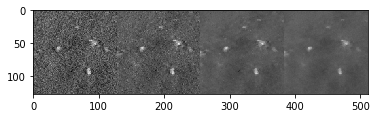

In [169]:
# For getting a Patch from  all the recon volumes

all_results =  []
for p in allp:
    temp_y = np.fromfile(p, dtype='float32')
    temp_y = temp_y.astype('float16')
    temp_y = np.reshape(temp_y, [48, 1200, 2600])
    temp = temp_y[24, 700+128:700+128*2, 1870+128:1870+128*2].astype('float32')
    all_results.append(temp)

plt.imshow(np.concatenate(all_results, axis=-1), cmap='gray')

In [164]:
model = load_model('/media/dril/Windows/newrecon2/newrecon/condition1.h5')

In [246]:
#np.save('x_array.npy', x_array)
#np.save('y_array.npy', y_array)
#np.save('z_array.npy', z_array)

In [224]:
#  Reading the Training Data for U-net Model No parameter

s = 2000

x_array = np.zeros([s, 128, 128, 5], dtype='float16')
y_array = np.zeros([s, 128, 128, 1], dtype='float16')
#z_array = np.zeros([s, 1], dtype='float16')

x       = []
input_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*"+str(0.0005)+"*_0.raw")
for p in input_p:
    temp = np.fromfile(p, dtype='float32')
    temp = np.reshape(temp, [48, 1200, 2600])
    x.append(temp)

output_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*4_"+str(0.0005)+"*.raw")

# y1 = np.fromfile(output_p[0], dtype='float32')
# y1 = np.reshape(y1, [48, 1200, 2600])

#y2 = np.fromfile(output_p[1], dtype='float32')
#y2 = np.reshape(y2, [48, 1200, 2600])

#y3 = np.fromfile(output_p[2], dtype='float32')
#y3 = np.reshape(y3, [48, 1200, 2600])

y4 = np.fromfile(output_p[3], dtype='float32')
y4 = np.reshape(y4, [48, 1200, 2600])


#x_array = []
#y_array = []
#z_array = []

counter   = 0
counter_x = 0

print("File Reading Done")

while(True):
    ix = np.random.randint(128, 1200-128)
    iy = np.random.randint(128, 1200-128)
    iz = np.random.randint(25, 40)
    
    tempx = x[0][iz, ix:ix+128, iy:iy+128]
    
    if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
        continue
    
#     tempy = y1[iz, ix:ix+128, iy:iy+128]
#     y_array[counter, :, :, 0] = tempy
#     counter = counter+1
    #y_array.append(tempy)
#     tempy = y2[iz, ix:ix+128, iy:iy+128]
#     y_array[counter, :, :, 0] = tempy
#     counter = counter+1
    #y_array.append(tempy)
#    tempy = y3[iz, ix:ix+128, iy:iy+128]
#    y_array[counter, :, :, 0] = tempy
#    counter = counter+1
#     #y_array.append(tempy)
    tempy = y4[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    #y_array.append(tempy)
    
    
    reg_value = [0.7]#[0.1, 0.3, 0.5, 0.7]
    for j in range(1):
        temp1 = []
        temp2 = []
        for k in range(5):
            x_array[counter_x, :, :, k] = x[k][iz, ix:ix+128, iy:iy+128]
            #temp1.append(x[k][iz, ix:ix+128, iy:iy+128])
            #temp2.append(np.ones(tempy.shape)*reg_value[j])
        #x_array[counter_x, :, :, :, 1] = temp2
        #z_array[counter_x, 0] = reg_value[j]
        counter_x = counter_x+1
    #z_array.append(*0.1)
    #z_array.append(np.ones(tempy.shape)*0.3)
    #z_array.append(np.ones(tempy.shape)*0.5)
    #z_array.append(np.ones(tempy.shape)*0.7)
    
    if counter_x == s:
        break

perm    = np.random.permutation(len(x_array))
x_array = x_array[perm]
y_array = y_array[perm]
z_array = np.array(z_array)[perm]

#x_array = np.expand_dims(x_array, axis=-1)
#y_array = np.expand_dims(y_array, axis=-1)
#z_array = np.expand_dims(z_array, axis=-1)

#print(x_array.shape, y_array.shape, z_array.shape)
print(x_array.shape, y_array.shape, z_array.shape)

File Reading Done
(2000, 128, 128, 5) (2000, 128, 128, 1) (2000, 1)


4248 [0.0002] [0.1]
[0.0002 0.0002 0.0002 0.0002 0.0002 0.0002]
[0.1 0.2 0.3 0.4 0.5 0.7]


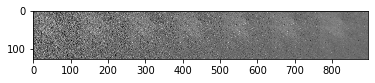

In [47]:
index = 6*random.randint(0, len(x_array)/6)
print(index, z1_array[index], z2_array[index])
print(z1_array[index: index+6].flatten())
print(z2_array[index: index+6].flatten())
plt.imshow(np.concatenate([x_array[index, :, :, 4].astype('float32'), 
                           y_array[index, :, :, 0].astype('float32'), 
                           y_array[index+1, :, :, 0].astype('float32'), 
                           y_array[index+2, :, :, 0].astype('float32'),
                           y_array[index+3, :, :, 0].astype('float32'),
                           y_array[index+4, :, :, 0].astype('float32'),
                           y_array[index+5, :, :, 0].astype('float32')
                          ], axis=-1), cmap='gray')

In [ ]:
#model = unet_double()
model.fit([x_array, z1_array*1000, z2_array], y_array, validation_split=0.2, batch_size=8, epochs=10000)
#model.fit([x_array, z_array], y_array, validation_split=0.2, batch_size=8, epochs=10000)
#model.fit(x_array, y_array, validation_split=0.2, batch_size=8, epochs=10000)

In [21]:
print(x_array.shape, y_array.shape, z_array.shape)
#plt.imshow(np.concatenate([x_array[100, :, :, 0], y_array[100, :, :, 0]], axis=-1), cmap='gray')

(9100, 128, 128, 1) (9100, 128, 128, 1) (7800, 1)


In [25]:
model = unet()
model.fit([x_array, z_array], y_array, validation_split=0.2, batch_size=8, epochs=10000)

Instructions for updating:
Use tf.cast instead.
Train on 6240 samples, validate on 1560 samples
Epoch 1/10000
6240/6240 [==============================] - 34s 5ms/step - loss: 0.0015 - mean_squared_error: 4.6368e-06 - val_loss: 0.0011 - val_mean_squared_error: 2.5916e-06
Epoch 2/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 9.2111e-04 - mean_squared_error: 1.7762e-06 - val_loss: 7.4864e-04 - val_mean_squared_error: 1.3363e-06
Epoch 3/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 6.8811e-04 - mean_squared_error: 1.0909e-06 - val_loss: 6.2390e-04 - val_mean_squared_error: 1.0348e-06
Epoch 4/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 6.1955e-04 - mean_squared_error: 8.9901e-07 - val_loss: 5.8965e-04 - val_mean_squared_error: 9.2737e-07
Epoch 5/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 5.9051e-04 - mean_squared_error: 8.1902e-07 - val_loss: 5.5390e-04 - val_mean_squared_error: 8.4

6240/6240 [==============================] - 29s 5ms/step - loss: 3.7005e-04 - mean_squared_error: 2.4737e-07 - val_loss: 4.0541e-04 - val_mean_squared_error: 4.2703e-07
Epoch 88/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 3.7036e-04 - mean_squared_error: 2.4735e-07 - val_loss: 4.0391e-04 - val_mean_squared_error: 4.3274e-07
Epoch 89/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 3.7014e-04 - mean_squared_error: 2.4688e-07 - val_loss: 4.0757e-04 - val_mean_squared_error: 4.4465e-07
Epoch 90/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 3.6918e-04 - mean_squared_error: 2.4533e-07 - val_loss: 4.0696e-04 - val_mean_squared_error: 4.2780e-07
Epoch 91/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 3.6821e-04 - mean_squared_error: 2.4351e-07 - val_loss: 4.0438e-04 - val_mean_squared_error: 4.3638e-07
Epoch 92/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 3.6732e-0

6240/6240 [==============================] - 30s 5ms/step - loss: 3.3854e-04 - mean_squared_error: 1.9807e-07 - val_loss: 3.9012e-04 - val_mean_squared_error: 3.9636e-07
Epoch 176/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.4009e-04 - mean_squared_error: 1.9953e-07 - val_loss: 3.9515e-04 - val_mean_squared_error: 3.9670e-07
Epoch 177/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.3701e-04 - mean_squared_error: 1.9628e-07 - val_loss: 3.8784e-04 - val_mean_squared_error: 3.9304e-07
Epoch 178/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.3674e-04 - mean_squared_error: 1.9550e-07 - val_loss: 3.8830e-04 - val_mean_squared_error: 3.9680e-07
Epoch 179/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.3947e-04 - mean_squared_error: 1.9859e-07 - val_loss: 3.9216e-04 - val_mean_squared_error: 3.9665e-07
Epoch 180/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.37

6240/6240 [==============================] - 30s 5ms/step - loss: 3.2309e-04 - mean_squared_error: 1.7851e-07 - val_loss: 3.8686e-04 - val_mean_squared_error: 3.9094e-07
Epoch 264/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.2253e-04 - mean_squared_error: 1.7792e-07 - val_loss: 3.8778e-04 - val_mean_squared_error: 3.9391e-07
Epoch 265/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.2119e-04 - mean_squared_error: 1.7627e-07 - val_loss: 3.8645e-04 - val_mean_squared_error: 3.8589e-07
Epoch 266/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.2338e-04 - mean_squared_error: 1.7887e-07 - val_loss: 3.8879e-04 - val_mean_squared_error: 4.0272e-07
Epoch 267/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.2294e-04 - mean_squared_error: 1.7832e-07 - val_loss: 3.8651e-04 - val_mean_squared_error: 3.8980e-07
Epoch 268/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.21

6240/6240 [==============================] - 30s 5ms/step - loss: 3.1172e-04 - mean_squared_error: 1.6582e-07 - val_loss: 3.8762e-04 - val_mean_squared_error: 3.8801e-07
Epoch 352/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.1092e-04 - mean_squared_error: 1.6505e-07 - val_loss: 3.8889e-04 - val_mean_squared_error: 3.8904e-07
Epoch 353/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.1161e-04 - mean_squared_error: 1.6568e-07 - val_loss: 3.9244e-04 - val_mean_squared_error: 4.0707e-07
Epoch 354/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 3.1106e-04 - mean_squared_error: 1.6517e-07 - val_loss: 3.9006e-04 - val_mean_squared_error: 3.9236e-07
Epoch 355/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.1106e-04 - mean_squared_error: 1.6518e-07 - val_loss: 3.9112e-04 - val_mean_squared_error: 3.9339e-07
Epoch 356/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.10

6240/6240 [==============================] - 30s 5ms/step - loss: 3.0466e-04 - mean_squared_error: 1.5864e-07 - val_loss: 3.9055e-04 - val_mean_squared_error: 3.9434e-07
Epoch 440/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.0327e-04 - mean_squared_error: 1.5694e-07 - val_loss: 3.9646e-04 - val_mean_squared_error: 3.9776e-07
Epoch 441/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.0363e-04 - mean_squared_error: 1.5728e-07 - val_loss: 3.9292e-04 - val_mean_squared_error: 3.9988e-07
Epoch 442/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.0476e-04 - mean_squared_error: 1.5843e-07 - val_loss: 3.9320e-04 - val_mean_squared_error: 3.9211e-07
Epoch 443/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.0321e-04 - mean_squared_error: 1.5697e-07 - val_loss: 3.9284e-04 - val_mean_squared_error: 3.9695e-07
Epoch 444/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 3.03

6240/6240 [==============================] - 29s 5ms/step - loss: 2.9709e-04 - mean_squared_error: 1.5053e-07 - val_loss: 3.9423e-04 - val_mean_squared_error: 3.9729e-07
Epoch 528/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.9924e-04 - mean_squared_error: 1.5283e-07 - val_loss: 3.9307e-04 - val_mean_squared_error: 4.0006e-07
Epoch 529/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 2.9772e-04 - mean_squared_error: 1.5123e-07 - val_loss: 3.9764e-04 - val_mean_squared_error: 3.9924e-07
Epoch 530/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.9723e-04 - mean_squared_error: 1.5081e-07 - val_loss: 3.9527e-04 - val_mean_squared_error: 3.9547e-07
Epoch 531/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.9772e-04 - mean_squared_error: 1.5123e-07 - val_loss: 3.9332e-04 - val_mean_squared_error: 3.9539e-07
Epoch 532/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.96

6240/6240 [==============================] - 30s 5ms/step - loss: 2.9209e-04 - mean_squared_error: 1.4536e-07 - val_loss: 3.9522e-04 - val_mean_squared_error: 3.9777e-07
Epoch 616/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.9390e-04 - mean_squared_error: 1.4735e-07 - val_loss: 3.9774e-04 - val_mean_squared_error: 3.9945e-07
Epoch 617/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.9438e-04 - mean_squared_error: 1.4804e-07 - val_loss: 3.9428e-04 - val_mean_squared_error: 3.9082e-07
Epoch 618/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.9227e-04 - mean_squared_error: 1.4571e-07 - val_loss: 3.9701e-04 - val_mean_squared_error: 4.0158e-07
Epoch 619/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.9358e-04 - mean_squared_error: 1.4693e-07 - val_loss: 3.9368e-04 - val_mean_squared_error: 3.9388e-07
Epoch 620/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.93

6240/6240 [==============================] - 30s 5ms/step - loss: 2.8970e-04 - mean_squared_error: 1.4301e-07 - val_loss: 3.9887e-04 - val_mean_squared_error: 4.0520e-07
Epoch 704/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8951e-04 - mean_squared_error: 1.4305e-07 - val_loss: 3.9487e-04 - val_mean_squared_error: 3.9436e-07
Epoch 705/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 2.8966e-04 - mean_squared_error: 1.4308e-07 - val_loss: 3.9684e-04 - val_mean_squared_error: 4.0375e-07
Epoch 706/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.9005e-04 - mean_squared_error: 1.4351e-07 - val_loss: 3.9502e-04 - val_mean_squared_error: 3.9636e-07
Epoch 707/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8889e-04 - mean_squared_error: 1.4231e-07 - val_loss: 3.9457e-04 - val_mean_squared_error: 3.9280e-07
Epoch 708/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.89

6240/6240 [==============================] - 29s 5ms/step - loss: 2.8621e-04 - mean_squared_error: 1.3986e-07 - val_loss: 3.9759e-04 - val_mean_squared_error: 4.0491e-07
Epoch 792/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8655e-04 - mean_squared_error: 1.4018e-07 - val_loss: 3.9628e-04 - val_mean_squared_error: 3.9649e-07
Epoch 793/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 2.8690e-04 - mean_squared_error: 1.4037e-07 - val_loss: 3.9670e-04 - val_mean_squared_error: 4.0040e-07
Epoch 794/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8781e-04 - mean_squared_error: 1.4139e-07 - val_loss: 3.9630e-04 - val_mean_squared_error: 3.9680e-07
Epoch 795/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8533e-04 - mean_squared_error: 1.3889e-07 - val_loss: 3.9694e-04 - val_mean_squared_error: 3.9371e-07
Epoch 796/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.87

6240/6240 [==============================] - 30s 5ms/step - loss: 2.8435e-04 - mean_squared_error: 1.3786e-07 - val_loss: 3.9701e-04 - val_mean_squared_error: 4.0018e-07
Epoch 880/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8463e-04 - mean_squared_error: 1.3823e-07 - val_loss: 3.9768e-04 - val_mean_squared_error: 3.9879e-07
Epoch 881/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8467e-04 - mean_squared_error: 1.3821e-07 - val_loss: 4.0048e-04 - val_mean_squared_error: 4.0437e-07
Epoch 882/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 2.8337e-04 - mean_squared_error: 1.3699e-07 - val_loss: 3.9607e-04 - val_mean_squared_error: 3.9381e-07
Epoch 883/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8457e-04 - mean_squared_error: 1.3805e-07 - val_loss: 3.9650e-04 - val_mean_squared_error: 3.9796e-07
Epoch 884/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.83

6240/6240 [==============================] - 30s 5ms/step - loss: 2.8221e-04 - mean_squared_error: 1.3577e-07 - val_loss: 3.9916e-04 - val_mean_squared_error: 4.0161e-07
Epoch 967/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8114e-04 - mean_squared_error: 1.3478e-07 - val_loss: 3.9707e-04 - val_mean_squared_error: 3.9867e-07
Epoch 968/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8257e-04 - mean_squared_error: 1.3621e-07 - val_loss: 3.9986e-04 - val_mean_squared_error: 4.0127e-07
Epoch 969/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8156e-04 - mean_squared_error: 1.3511e-07 - val_loss: 3.9827e-04 - val_mean_squared_error: 3.9748e-07
Epoch 970/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 2.8244e-04 - mean_squared_error: 1.3610e-07 - val_loss: 3.9903e-04 - val_mean_squared_error: 4.0392e-07
Epoch 971/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.81

6240/6240 [==============================] - 30s 5ms/step - loss: 2.8066e-04 - mean_squared_error: 1.3449e-07 - val_loss: 3.9972e-04 - val_mean_squared_error: 4.0310e-07
Epoch 1011/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8163e-04 - mean_squared_error: 1.3531e-07 - val_loss: 3.9886e-04 - val_mean_squared_error: 4.0084e-07
Epoch 1012/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8026e-04 - mean_squared_error: 1.3392e-07 - val_loss: 3.9879e-04 - val_mean_squared_error: 3.9267e-07
Epoch 1013/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8068e-04 - mean_squared_error: 1.3445e-07 - val_loss: 3.9872e-04 - val_mean_squared_error: 4.0101e-07
Epoch 1014/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.8134e-04 - mean_squared_error: 1.3497e-07 - val_loss: 3.9943e-04 - val_mean_squared_error: 4.0181e-07
Epoch 1015/10000
6240/6240 [==============================] - 30s 5ms/step - loss:

Epoch 1097/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.7932e-04 - mean_squared_error: 1.3319e-07 - val_loss: 3.9935e-04 - val_mean_squared_error: 3.9702e-07
Epoch 1098/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.7946e-04 - mean_squared_error: 1.3321e-07 - val_loss: 3.9869e-04 - val_mean_squared_error: 4.0500e-07
Epoch 1099/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 2.7974e-04 - mean_squared_error: 1.3339e-07 - val_loss: 3.9870e-04 - val_mean_squared_error: 3.9954e-07
Epoch 1100/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.7823e-04 - mean_squared_error: 1.3206e-07 - val_loss: 3.9833e-04 - val_mean_squared_error: 4.0018e-07
Epoch 1101/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.7988e-04 - mean_squared_error: 1.3364e-07 - val_loss: 3.9926e-04 - val_mean_squared_error: 4.0404e-07
Epoch 1102/10000
6240/6240 [==============================] - 30s

6240/6240 [==============================] - 30s 5ms/step - loss: 2.7779e-04 - mean_squared_error: 1.3163e-07 - val_loss: 3.9996e-04 - val_mean_squared_error: 3.9687e-07
Epoch 1184/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 2.7793e-04 - mean_squared_error: 1.3180e-07 - val_loss: 3.9948e-04 - val_mean_squared_error: 4.0280e-07
Epoch 1185/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.7708e-04 - mean_squared_error: 1.3101e-07 - val_loss: 3.9911e-04 - val_mean_squared_error: 4.0057e-07
Epoch 1186/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 2.7802e-04 - mean_squared_error: 1.3194e-07 - val_loss: 3.9949e-04 - val_mean_squared_error: 4.0093e-07
Epoch 1187/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.7767e-04 - mean_squared_error: 1.3152e-07 - val_loss: 3.9841e-04 - val_mean_squared_error: 3.9911e-07
Epoch 1188/10000
6240/6240 [==============================] - 30s 5ms/step - loss:

Epoch 1227/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.7734e-04 - mean_squared_error: 1.3117e-07 - val_loss: 4.0006e-04 - val_mean_squared_error: 4.0591e-07
Epoch 1228/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 2.7680e-04 - mean_squared_error: 1.3073e-07 - val_loss: 4.0003e-04 - val_mean_squared_error: 4.0188e-07
Epoch 1229/10000
6240/6240 [==============================] - 29s 5ms/step - loss: 2.7672e-04 - mean_squared_error: 1.3058e-07 - val_loss: 4.0096e-04 - val_mean_squared_error: 4.0158e-07
Epoch 1230/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.7757e-04 - mean_squared_error: 1.3135e-07 - val_loss: 4.0059e-04 - val_mean_squared_error: 4.0462e-07
Epoch 1231/10000
6240/6240 [==============================] - 30s 5ms/step - loss: 2.7605e-04 - mean_squared_error: 1.2997e-07 - val_loss: 3.9999e-04 - val_mean_squared_error: 4.0327e-07
Epoch 1232/10000
6240/6240 [==============================] - 30s

KeyboardInterrupt: 

In [ ]:
model = load_model('/media/dril/Windows/newrecon2/newrecon/condition4-0.5.h5')
#print(model.summary())

In [57]:
model.save("condition-all-2-both-parameters.h5")
#model.save("condition1.h5")

In [26]:
result_single = model.predict([x_array, z_array], batch_size=16)
#result1 = model.predict([x_array, z_array+2], batch_size=16)
#result2 = model.predict([x_array, z_array+1], batch_size=16)
#result3 = model.predict([x_array, z_array+1.5], batch_size=16)

[0.3]


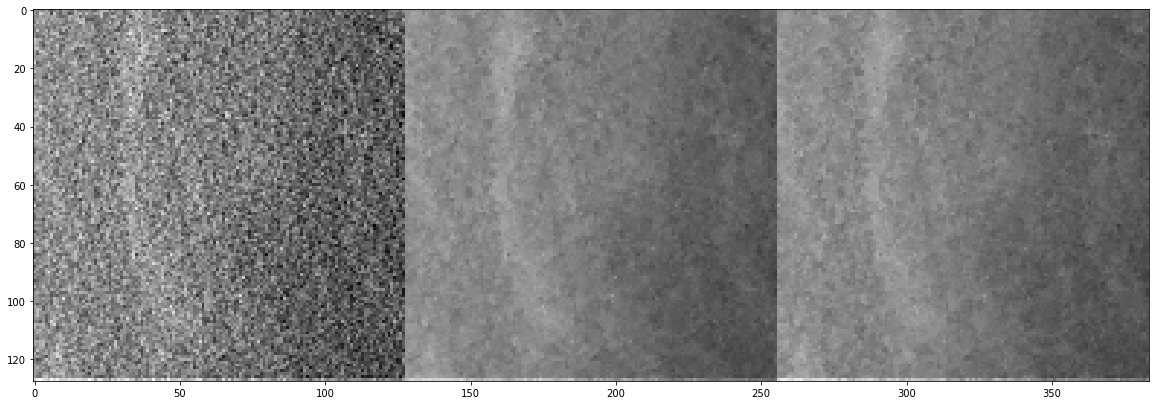

In [54]:
index = np.random.randint(int(len(x_array)*0.8), len(x_array))
plt.figure(figsize=(20,10))
print(z_array[index])
#print(z1_array[index], z2_array[index])
plt.imshow(np.concatenate([x_array[index, :, :, 0], result_single[index, :, :, 0], y_array[index, :, :, 0]], axis=-1), cmap='gray') 
#plt.imshow(np.concatenate([x_array[index, :, :, 4], result_single[index, :, :, 0], y_array[index, :, :, 0], 15*np.abs(result_single[index, :, :, 0]- y_array[index, :, :, 0])], axis=-1), cmap='gray') 

[0.3]


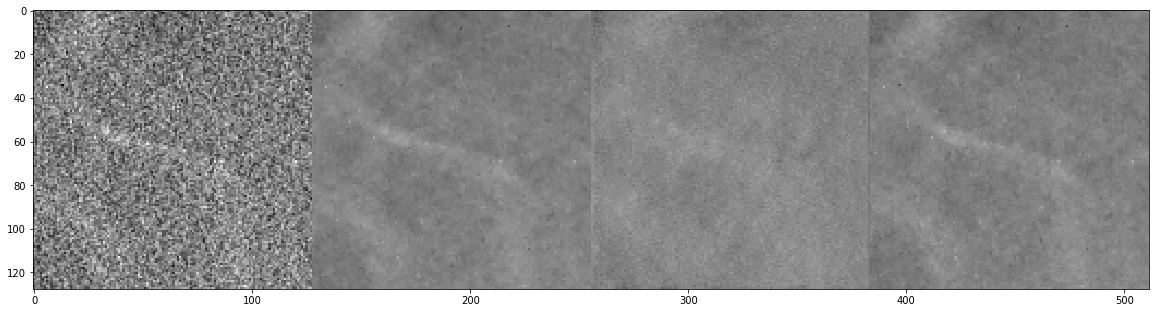

In [156]:
index = np.random.randint(0, len(x_array))
print(z_array[index])
plt.figure(figsize=(20,10))
plt.imshow(np.concatenate([x_array[index, :, :, 4], result[index, :, :, 0], result1[index, :, :, 0], y_array[index, :, :, 0]], axis=-1), cmap='gray')

In [30]:
# Training the Deep Model

beta_array = [0.1, 0.3, 0.5, 0.7]

for beta in beta_array:
    
a = np.fromfile('/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18_2600x1200x48.4_0.0005_-0.5.raw', dtype='float32')
a = np.reshape(a, [ 48, 1200, 2600])
b = np.fromfile('/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18_2600x1200x48.4_0.0005_0.raw', dtype='float32')
b = np.reshape(b, [ 48, 1200, 2600])

print(a.shape)

(48, 1200, 2600)


In [22]:
# Output image patches

y_raw_array = []
output_p    = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27*4_*.raw")
output_p.sort()
output_p_new = []
counter      = 0
for t in output_p:
    if '_0.raw' not in t and '.0003' not in t and '.0001' not in t and '.0006' not in t and '0.2' not in t and '0.4' not in t:
        print(counter, t)
        output_p_new.append(t)
        counter = counter+1
output_p = output_p_new

for p in output_p:
    #print(p)
    temp_y = np.fromfile(p, dtype='float32')
    temp_y = temp_y.astype('float16')
    temp_y = np.reshape(temp_y, [48, 1200, 2600])
    y_raw_array.append(temp_y)

0 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0002_-0.1.raw
1 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0002_-0.3.raw
2 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0002_-0.5.raw
3 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0002_-0.7.raw
4 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0005_-0.1.raw
5 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0005_-0.3.raw
6 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0005_-0.5.raw
7 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0005_-0.7.raw
8 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0007_-0.1.raw
9 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0007_-0.3.raw
10 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0007_-0.5.raw
11 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0007_-0.7.raw
12

In [17]:
# Input Image patches

arr1 = [0.0002, 0.0005, 0.0007, 0.001]
arr2 = [0.1,  0.3,  0.5, 0.7]

output_p_new1 = []

for a1 in arr1:
    for a2 in arr2:
        y_raw_array = []
        output_p    = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27*"+str(a1)+"*"+str(a2)+".raw")
        output_p.sort()
        counter      = 0
        for f in output_p:
            #print(f)
            output_p_new1.append(f)
        print("*************************")

output_p_new = []
counter      = 0
for t in output_p_new1:
    if '_0.raw' not in t and '.0003' not in t and '.0001' not in t and '.0006' not in t and '0.2' not in t and '0.4' not in t:
        print(counter, t)
        output_p_new.append(t)
        counter = counter+1
output_p = output_p_new

for p in output_p_new:
    print(p)

*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
*************************
0 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.0_0.0002_-0.1.raw
1 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.1_0.0002_-0.1.raw
2 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.2_0.0002_-0.1.raw
3 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.3_0.0002_-0.1.raw
4 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0002_-0.1.raw
5 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.0_0.0002_-0.3.raw
6 /media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.1_0.0002_-0.3.raw
7 /

In [19]:
y_raw_array1 = []

for p in output_p_new:
    print(p)
    temp_y = np.fromfile(p, dtype='float32')
    temp_y = temp_y.astype('float16')
    temp_y = np.reshape(temp_y, [48, 1200, 2600])
    y_raw_array1.append(temp_y)

/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.0_0.0002_-0.1.raw
/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.1_0.0002_-0.1.raw
/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.2_0.0002_-0.1.raw
/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.3_0.0002_-0.1.raw
/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0002_-0.1.raw
/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.0_0.0002_-0.3.raw
/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.1_0.0002_-0.3.raw
/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.2_0.0002_-0.3.raw
/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.3_0.0002_-0.3.raw
/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0002_-0.3.raw
/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.0_0.0002_-0.5.raw
/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.1_0.0002_-0.5.raw
/media/dril/My Passport/DBT-

(16, 128, 128, 1) (16, 128, 128, 5) (16, 1) (16, 1)


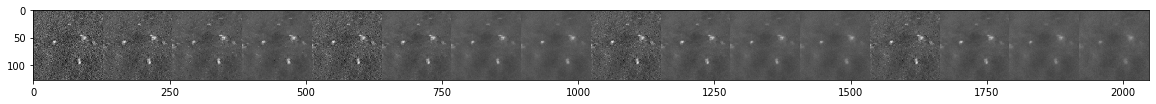

In [26]:
arr1 = [0.0002, 0.0005, 0.0007, 0.001]
arr2 = [0.1,  0.3,  0.5, 0.7]

all_results =  []
all_results_x =  []
index       = 0

z1_array = []
z2_array = []

for a1 in arr1:
    for a2 in arr2:
        temp_x = np.zeros([128, 128, 5])
        for k in range(5):
            temp_y = y_raw_array1[index*5+k]
            temp   = temp_y[24, 700+128:700+128*2, 1870+128:1870+128*2].astype('float32')
            temp_x[:, :, k] = temp
        all_results_x.append(temp_x)
        
        temp_y = y_raw_array[index]
        temp   = temp_y[24, 700+128:700+128*2, 1870+128:1870+128*2].astype('float32')
        all_results.append(temp)
        index = index+1
        
        z1_array.append(a1)
        z2_array.append(a2)
    
#for p in range(len(y_raw_array)):
#    #temp_y = np.fromfile(p, dtype='float32')
#    #temp_y = temp_y.astype('float16')
#    #temp_y = np.reshape(temp_y, [48, 1200, 2600])
    

plt.figure(figsize=(20,10))
plt.imshow(np.concatenate(all_results, axis=-1), cmap='gray')

all_results_x = np.array(all_results_x)
all_results   = np.array(all_results)


all_results = np.expand_dims(all_results, axis=-1)
z1_array    = np.expand_dims(z1_array, axis=-1)
z2_array    = np.expand_dims(z2_array, axis=-1)

print(all_results.shape, all_results_x.shape, z1_array.shape, z2_array.shape)

In [5]:
model = load_model("/media/dril/Windows/newrecon2/newrecon/condition-all-2-both-parameters.h5")
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 128, 128, 5)  0                                            
________________________________________________________________________

In [6]:
z1_array = np.load('z1_array.npy')
z2_array = np.load('z2_array.npy')
all_results_x = np.load('all_results_x.npy')

In [31]:
np.save('all_results_x.npy', all_results_x)
np.save('z1_array.npy', z1_array)
np.save('z2_array.npy', z2_array)

In [7]:
result  = model.predict([all_results_x, z1_array*1000, z2_array], batch_size=8)
print(result.shape)

(16, 128, 128, 1)


In [7]:
print(host_prj_allangle.shape)
#plt.figure(figsize=(20,10))
#plt.imshow(np.concatenate(result[:, :, :, 0], axis=0).T, cmap='gray')

(143360000,)
